# Pair Trading with Machine Learning

### W207 Applied Machine Learning
#### Ash Moinzadeh, Shrey Singhal, Alejandro Reskala
#### Repo: https://github.com/UC-Berkeley-I-School/moinzadeh_reskala_singhal_w207_final
<HR>

<a id='0'></a>
# 1. Introduction

A key component of any economy is a ***stock exchange***, which is a market where securities are purchased and sold. The S&P 500 is widely regarded as the best single gauge of the large-cap U.S. equity market, and is the world’s most tracked index on an "Assets Under Management" (AUM) basis. The index includes 503 leading companies and covers approximately 80% of the U.S. equity market. These companies are distributed over 11 sectors according to the Global Industry Classification Standard (GICS): Energy, Materials, Industrials, Consumer Discretionary, Consumer Staples, Health Care, Financials, Information Technology, Communication Services, Real Estate, and Utilities.

While it may appear sensible to invest in an individual stock (or the broader index) by observing its temporal trends, there is no guarantee that these trends, alone, will provide high returns. This is because there are a number of underlying changes in the market that cannot be readily observed, which means that "riding a peak" can only take an investor so far without incurring losses. To improve the risk/reward ration for investors seeking to profit from the S&P 500 index, a more ppopular and reliable investment strategy involves identifying pairs of stocks that share similarities with each other. 

***Pair Trading*** is a non-directional, and relative value, investment strategy that seeks to identify 2 companies, with similar characteristics, and whose equity securities are currently trading at a price relationship that is outside of their historical trading range. A Pair Trading strategy entails, for an given pair of stocks, buying the undervalued security in that pair while short-selling the overvalued security, all while maintaining market neutrality. Pair trading strategies can be framed as market neutral because they seeks to profit from the trajectory of both stocks in the trading pair while minimizing any net losses incurred by the market as a whole. They likewise can be viewed as a statistical arbitrage, because statistical arbitrages are characterized by a simultaneous commitment to both long and short investment positions. All in all, Pair Trading is a commonly used quantitative trading strategy used in hedge funds and investment banks, because it allows for widespread analysis and prediction amongst a pair of highly correlated stocks.

The gist of pair trading is as follows: let's say we have a pair of securities X and Y that have some underlying economic link. An example might be two companies that manufacture the same product, or two companies in one supply chain. If we can model this economic link with a machine learning model, we can make trades that depend on this link.

However, it should be noted that the creation of trading pairs depends on both algorithmic precision and efficiency. If we only use time series analysis to identify trading pairs between 500 stocks, we will have to screen across 500 * 499 = 249,500 pair candidates, with each stock containing 5 years worth of pricing data. While this approach ensures that algorithmic precision is prioritized when identifying trading pairs, algorithmic efficiency is greatly impaired due to the sheer load of candidates being screened. To diminish the size of this hurdle, this strategy incorporates an algorithmic clustering approach to identify behavioral similarities on a macro, and technical, level. K-Means Clustering, Hierarchical Clustering and Affinity Propagation are used to cluster stocks, and silhouette scores are calculated to determine which of these three clustering methods generates the best defined, and cohesive, clusters. By taking this measure alone, the number of pair candidates designated for time series analysis drops by a factor of 3.5-fold.

***In short, our goal in this study is to perform clustering analysis on all the stocks of S&P 500 index, and to identify trading pairs that lead to a profitable trading strategy and can be integrated into a live environment.*** 

<a id='1'></a>
# 2. Getting Started - Loading data & packages

## Process Flow

In [1]:
%pip install missingno
%pip install ta
%pip install pandas_datareader
%pip install kneed
%pip install pykalman
%pip install plotly
%pip install statsmodels


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import Dependencies:
## Note: You may have to install a number of packages prior to running this notebook.
import numpy as np
import pandas as pd
import os
import glob
import pickle as pickle
import json
# import missingno
import itertools
from itertools import cycle
from datetime import datetime
from builtins import object
from datetime import date
from dateutil.relativedelta import relativedelta
from collections import defaultdict
from concurrent import futures
from pandas import set_option
import ta
# import pandas_datareader.data as web
import warnings
import random
warnings.filterwarnings('ignore')

#visualization dependencies
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from plotly import graph_objects as go
from plotly import offline as py
import plotly.express as px
%matplotlib inline

#machine learning/statistical dependencies
import statsmodels.api as sm
from kneed import KneeLocator
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from sklearn.manifold import TSNE
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima.model import ARIMA 
# from pykalman import KalmanFilter
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout
import scipy.cluster.hierarchy as shc

import gc

#displaying
# set_option('precision', 3)

/tmp/ipykernel_6125/3840839109.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-11 20:58:47.113444: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-11 20:58:47.147228: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)


## Data Gathering

We scrape the web to gather the financial data of S&P 500 companies for last 5 years. This data will initially be stored **as a table** called `combined_data`. In latter sections, `combined_data` and will be transformed into `final_data`, which will be used for Time Series Analysis (TSA) and the proposed pair trading strategy. A subset of `final_data`, called `X`, will similarly be extracted and utilized for cluster identification prior to TSA. 

**Data Sources** 

* The ticker, sector and industry metadata for S&P 500 companies was scraped from Wikipidea.
    ([https://en.wikipedia.org/wiki/List_of_S%26P_500_companies]('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'))
    
* The financial information for each company was gathered using python's `pandas_datareader` library, with company tickers being used as identifiers.

We developed a class called `gather_data`, which encapculates all the functions utilized in this data gathering process.

Here's a quick overview the functions associated with `gather_data`:

* `download_s_and_p_stats()`: Fetches S&P 500 company metadata (ticker, sector, industry) from Wikipidea.

* `download_stock_financials()`: Fetches financial data (open, low, high, close, volume, adj close) associated with a given stock's ticker.

* `MultiThreader()`: Uses a *multi-threading* approach to speed up the stock data collection rate. 
  - For clarification, a multi-threading approach allocates multiple components of a CPU to perform a collective task. This allows for data to be processed in parallel, thereby improving the algorithmic efficiency of this strategy.

* `combine_stock_data()`: Compiles all of the stock CSV data files into a combined file. 

The data gathering process consists of the following steps:
1. The `MultiThreader()` is called through a class object. It utilizes the `download_s_and_p_stats()` method to fetch the stock metadata. This metadata is then passed to the `download_stock_financials()` method with a maximum of 50 parallel workers.

2. The `download_stock_financials()` method extracts ticker information from each stock's metadata. The start and end dates associated with this ticker information are used to fetch the financial data of each given stock under the specified timeframe.

3. This financial data is merged with the metadata for each stock, and a CSV file for each stock is created and stored in it its own "Individual Stocks" directory.

4. Finally, the `combine_stock_data()` method merges all the gathered stock CSV files into one dataframe and optionally stores it in a final "Data" directory.

In [4]:
combined_data = pd.read_csv('./1999-12-01-2023-12-31.csv')

In [5]:
# Display the first 5 rows of the combined pivot dataset
combined_data.head()

Date   Open   High    Low  Close  Adj Close      Volume Ticker  \
0  1999-12-01 47.344 47.625 46.781 47.219     24.405 2062600.000    MMM   
1  1999-12-02 47.500 49.219 47.469 48.594     25.116 2617400.000    MMM   
2  1999-12-03 48.750 50.406 48.750 49.656     25.665 3060600.000    MMM   
3  1999-12-06 49.250 49.531 48.688 48.906     25.277 1282200.000    MMM   
4  1999-12-07 48.750 48.750 46.500 46.500     24.034 2190400.000    MMM   

   GICS Sector         GICS Sub-Industry  
0  Industrials  Industrial Conglomerates  
1  Industrials  Industrial Conglomerates  
2  Industrials  Industrial Conglomerates  
3  Industrials  Industrial Conglomerates  
4  Industrials  Industrial Conglomerates

<a id='2'></a>
# 3. Exploratory Data Analysis

The data preprocessing part contains 3 steps:
1. **Feature Engineering and Data Cleansing:**
    We apply feature engineering on the data to extract multiple technical indicators which might help us to understand and realize the link between two stockss.
    
    To do this, we make use of the `generate_technical_indicator()` method from the `feature_engineering` class to add aditional features to a given stock's financial data. This means that `combined_data` is transformed into `final_data` in this step. 

    Null values are removed from rows in `final_data` that pertain specifically to `Date`, `Close` and `daily_returns`. An explanation is provided below, prior to NA removal.
    
    
2. **Cluster-Level Data Preparation:**
    Mean return and volatility data is pulled from `final_data`, and clusters will be generated on this data in **Section 4**.
    
    
3. **Preliminary Graphing:**
    A preliminary view of stock-associated covariates can provide more information on how balanced these covariates are within the compiled dataset. Even though we are focused on *relationships* between paired stocks, it is imperative that we first examine the full landscape of stock measurements in the index. This will give us more context on how the market, as a whole, is performing, as well as what our machine learning algorithms will fit to.

    The following graphs will be examined:
    
    - S&P 500 Index Closing Prices Over Time.
    - Returns vs. Volatilities Across All Stocks, Unclustered.

### 3.1: **Feature Engineering and Data Cleansing:**

There are various technical indicators that can be used to identify trading pairs. Each of these technical indicators builds off of closing price data for a given stock, and can be formulaically applied to the closing data of the dataset compiled in the "Data Gathering" section. For ease of application, the `statsmodels.tsa.stattools` package comes with all of these technical formulae in a Python-scripted format.

For clarification, here are the definitions for the indicators that will be used in this strategy:

*   **Relative Strength Index (RSI)** - A momentum indicator used by traders to analyze bullish behavior when a stock is oversold, or bearish behavior when a stock is overbought.

$$\text{RSI} = 100 - \frac{100}{1 + RS}$$ 

$$\text{RS} = -\frac{AvgGain_{prev}  * 13 + Current Gain}{AvgLoss_{prev}  * 13 + Current Loss}$$ 

*   **Kufman's Adaptive Moving Average (KAMA)** - Accounts for the noise and volatile nature of the market. It closely follows prices when noise is low and smooths out the noise when prices fluctuate. It can be used to identify the turning points and price movements of a given stock.


*   **Accumulation/Distribution Index (ADI)** - Acts as a leading indicator of price movements relative to the volume.

$$\text{CLV} = \frac{(close - low) - (high - close)}{high-low}$$ 

$$\text{accdist} = accdist_{prev} + volume * CLV $$

*   **Volume Price Trend (VPT)** - Adds or substracts a multiple of the percent-change in share price trends and current volumes. It depends upon a given stock's upward and downward movements, and is calibrated towards a stock's running cumulative volume.

$$\text{VPT} = VPT_{prev} + volume * \frac{(close_{today} - close_{prev})}{close_{prev}}$$ 

* **Average True Range (ATR)** - Provides the degree of price volatility over a time period of n specified days.
$$\text{ATR} = \frac{1}{n}\sum_{i=1}^{n}TR_{i}$$ 

$$\text{TR} = max[(high-low), abs(high - close_{prev}),abs(close_{prev} - low)]$$ 

* **Bollinger M-Band** - Simple moving average of closing prices over time. The Bollinger M-Band derives from a broader-defined Bollinger Band, which assesses moving averages alongside upper and lower bounds.

$$\text{BB} = n - MA_{daily} $$

* **Exponential Moving Average (EMA)** - Calculated moving averages along an exponential scale.

$$\text{EMA} = [Close - EMA_{prev}] * \frac{2}{n+1} + EMA_{prev} $$

* **Average Directional Movement Index (ADMI)** - Indicates the strength of the trend for a given stock. The strength can likewise be framed as a kind of inertia, or persistance, in a trend's upwards or downwards movement. The ADMI is composed of two indicators, a positive directional indicator (+DI) and a negative directional indicator(-DI).


* **Moving Average Convergence Divergence** - Shows the relationship between two moving price averages in a given time window.


* **Daily Returns** - The percentage gained from a previous day's closing price.

$$\text{Log Return} = \frac{Close_i}{Close_{i-1}}*100\% $$

* **Log Returns** - The percentage gained from a previous day's closing price, measured logarithmically.

$$\text{Log Return} = ln (\frac{Close_i}{Close_{i-1}}*100\%) $$

**Note:** - We do not use all of these technical indicators in our analysis so far, but we continue to highlight them and build them in our data below so that we can easily extend our work further post this course.

*Reference*: Wikipedia

In [6]:
class feature_engineering(object):
    def __init__(self):
        super(feature_engineering, self).__init__()

    def generate_technical_indicator(self, data_df): 
        '''
        Function to generate additional technical indicators for the stock

        Uses the "statsmodels.tsa.stattools" (as "ts") package to apply 
        the equations specified in the "Technical Indicators" markdown section 
        to stock closing data.
        
        Input:
        data_df-- Dataframe containing stock finacials data
        
        Output:
        Stock finacials data with added Dataframe of feature obtained from feature engineering
        ''' 
        # 1. Momentum Indicators
        # Relative Strength Index
        df = data_df
        df['rsi'] = ta.momentum.rsi(df['Close'], window=14)
        # Kaufman’s Adaptive Moving Average (KAMA)
        df['kama'] = ta.momentum.kama(df['Close'],window=14)

        # 2. Volume Indicators
        # Accumulation/Distribution Index (ADI)
        df['adi'] = ta.volume.acc_dist_index(df['High'], df['Low'], df['Close'], df['Volume'])

        # Volume-price trend (VPT)
        df['vpt'] = ta.volume.volume_price_trend(df['Close'], df['Volume'])

        # 3. Volatility Indicators
        # Average True Range (ATR)
        df['atr'] = ta.volatility.average_true_range(df['High'], df['Low'],df['Close'], window=14)

        # Bollinger Bands (BB) N-period simple moving average (MA)
        df['bb_ma'] = ta.volatility.bollinger_mavg(df['Close'], window=20)

        # 4. Trend Indicators
        # Average Directional Movement Index (ADX)
        df['adx'] = ta.trend.adx(df['High'], df['Low'], df['Close'], window=14)

        # Exponential Moving Average
        df['ema'] = ta.trend.ema_indicator(df['Close'], window=14)

        # Moving Average Convergence Divergence (MACD)
        df['macd'] = ta.trend.macd(df['Close'], window_fast=14, window_slow=30)

        # 5. Other Indicators
        # Daily Log Return (DLR)
        df['dlr'] = ta.others.daily_log_return(df['Close'])

        # Daily Returns
        df['daily_returns'] = df['Adj Close'].pct_change()

        # Moving Averages
        averages = [50,200]
        for avg in averages:
            col_name = str(avg) +' Days Average'
            df[col_name] = df['Adj Close'].rolling(window = avg, center = False).mean()

        return df

In [7]:
# Create an instance of the feature_engineering class object
fe_obj = feature_engineering()

# Add technical indicators to combined_data
final_data = fe_obj.generate_technical_indicator(combined_data)
final_data.head()

Date   Open   High    Low  Close  Adj Close      Volume Ticker  \
0  1999-12-01 47.344 47.625 46.781 47.219     24.405 2062600.000    MMM   
1  1999-12-02 47.500 49.219 47.469 48.594     25.116 2617400.000    MMM   
2  1999-12-03 48.750 50.406 48.750 49.656     25.665 3060600.000    MMM   
3  1999-12-06 49.250 49.531 48.688 48.906     25.277 1282200.000    MMM   
4  1999-12-07 48.750 48.750 46.500 46.500     24.034 2190400.000    MMM   

   GICS Sector         GICS Sub-Industry  ...        vpt   atr  bb_ma   adx  \
0  Industrials  Industrial Conglomerates  ...        NaN 0.000    NaN 0.000   
1  Industrials  Industrial Conglomerates  ...  76218.134 0.000    NaN 0.000   
2  Industrials  Industrial Conglomerates  ... 143138.005 0.000    NaN 0.000   
3  Industrials  Industrial Conglomerates  ... 123771.863 0.000    NaN 0.000   
4  Industrials  Industrial Conglomerates  ...  16001.384 0.000    NaN 0.000   

   ema  macd    dlr  daily_returns  50 Days Average  200 Days Average  
0  NaN   NaN    NaN            NaN              NaN               NaN  
1  NaN   NaN  2.870          0.029              NaN               NaN  
2  NaN   NaN  2.163          0.022              NaN               NaN  
3  NaN   NaN -1.522         -0.015              NaN               NaN  
4  NaN   NaN -5.045         -0.049              NaN               NaN  

[5 rows x 23 columns]

Null values contained in `final_data` will be provided a preliminary screening. 
- Given that the most relevant information for all technical indicators, as well as for downstream machine learning, are the `Date`, `Close` and `daily_returns` features, **only null values from these features will be removed.** 
- While it may appear as if NA values are being avoided for technical indicators, it should be noted that **many of these technical indicators depend on multiple days-worth of data before and after our cutoff timeframe.** With that in mind, NA values should be expected on dates that bound our timeframe.

In [8]:
# Examine Null Values in final_data. Examine Date, Close and daily_returns.
final_data.isna().sum()

Date                   0
Open                   0
High                   0
Low                    0
Close                  0
Adj Close              0
Volume                 0
Ticker                 0
GICS Sector            0
GICS Sub-Industry      0
rsi                   13
kama                  13
adi                    0
vpt                    1
atr                    0
bb_ma                 19
adx                    0
ema                   13
macd                  29
dlr                    1
daily_returns          1
50 Days Average       49
200 Days Average     199
dtype: int64

In [9]:
# Remove Null Values from "Date", "Close" and "daily_returns"
final_data = final_data.dropna(subset=['Date', 'Close','daily_returns'])
np.shape(final_data)

(2701712, 23)

In [10]:
# Review Results of Null Removal.
final_data.isna().sum()

Date                   0
Open                   0
High                   0
Low                    0
Close                  0
Adj Close              0
Volume                 0
Ticker                 0
GICS Sector            0
GICS Sub-Industry      0
rsi                   12
kama                  12
adi                    0
vpt                    0
atr                    0
bb_ma                 18
adx                    0
ema                   12
macd                  28
dlr                    0
daily_returns          0
50 Days Average       48
200 Days Average     198
dtype: int64

`final_data` is now complete, and will be primarily used in **Section 7**. The head of the dataset is displayed below. 

In [11]:
final_data.head()

Date   Open   High    Low  Close  Adj Close      Volume Ticker  \
1  1999-12-02 47.500 49.219 47.469 48.594     25.116 2617400.000    MMM   
2  1999-12-03 48.750 50.406 48.750 49.656     25.665 3060600.000    MMM   
3  1999-12-06 49.250 49.531 48.688 48.906     25.277 1282200.000    MMM   
4  1999-12-07 48.750 48.750 46.500 46.500     24.034 2190400.000    MMM   
5  1999-12-08 46.938 47.719 46.562 47.000     24.292 2124600.000    MMM   

   GICS Sector         GICS Sub-Industry  ...        vpt   atr  bb_ma   adx  \
1  Industrials  Industrial Conglomerates  ...  76218.134 0.000    NaN 0.000   
2  Industrials  Industrial Conglomerates  ... 143138.005 0.000    NaN 0.000   
3  Industrials  Industrial Conglomerates  ... 123771.863 0.000    NaN 0.000   
4  Industrials  Industrial Conglomerates  ...  16001.384 0.000    NaN 0.000   
5  Industrials  Industrial Conglomerates  ...  38846.545 0.000    NaN 0.000   

   ema  macd    dlr  daily_returns  50 Days Average  200 Days Average  
1  NaN   NaN  2.870          0.029              NaN               NaN  
2  NaN   NaN  2.163          0.022              NaN               NaN  
3  NaN   NaN -1.522         -0.015              NaN               NaN  
4  NaN   NaN -5.045         -0.049              NaN               NaN  
5  NaN   NaN  1.070          0.011              NaN               NaN  

[5 rows x 23 columns]

In [12]:
final_data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker',
       'GICS Sector', 'GICS Sub-Industry', 'rsi', 'kama', 'adi', 'vpt', 'atr',
       'bb_ma', 'adx', 'ema', 'macd', 'dlr', 'daily_returns',
       '50 Days Average', '200 Days Average'],
      dtype='object')

### 3.2: **Cluster-Level Data Preparation:**
To ensure efficient identification of trading pairs, stocks will be grouped into clusters based on descriptive statistical behaviors. Each stock will be extracted from the `final_data` pivot table along with closing price data, and will be stored in `exp_data` for additional cleansing.

- The primary fields of interest are the `mean` and `std` of the closing price data. These will be used in **Section 5**, for Clustering Identification.
    
- It should be noted that a number of NA values exist for the `mean` and `std` values of various stocks. This is because these stocks have at least one NA value in the ticker-level data. These stocks will be removed from the entire clustering analysis. 

- Once these stocks are removed from `exp_data`, the mean and standard deviation of each stock's closing data will be stored in a dataframe called `X`. The mean and standard deviation are also known as the mean returns (simply "returns" in this dataset) and volatility in finance. They will be stored as `returns` and `volatility` in `X`.

In [13]:
df = final_data.pivot(index='Date', columns='Ticker', values='Close') 
df.head()

Ticker          A  AAL  AAPL  ABBV  ABNB    ABT  ACGL  ACN   ADBE    ADI  ...  \
Date                                                                      ...   
1999-12-01 30.714  NaN 0.920   NaN   NaN 16.806 1.389  NaN 16.641 30.250  ...   
1999-12-02 31.563  NaN 0.984   NaN   NaN 16.869 1.458  NaN 17.156 35.031  ...   
1999-12-03 31.831  NaN 1.027   NaN   NaN 16.806 1.434  NaN 16.672 34.812  ...   
1999-12-06 32.725  NaN 1.036   NaN   NaN 16.329 1.361  NaN 15.781 37.062  ...   
1999-12-07 32.368  NaN 1.052   NaN   NaN 16.076 1.333  NaN 15.156 36.406  ...   

Ticker      WYNN    XEL    XOM  XRAY  XYL   YUM  ZBH   ZBRA   ZION  ZTS  
Date                                                                     
1999-12-01   NaN 20.375 41.250 7.812  NaN 7.313  NaN 26.444 65.312  NaN  
1999-12-02   NaN 20.375 41.039 7.646  NaN 7.234  NaN 25.556 65.875  NaN  
1999-12-03   NaN 20.562 41.266 7.958  NaN 7.189  NaN 25.944 67.562  NaN  
1999-12-06   NaN 20.625 41.938 7.688  NaN 7.200  NaN 25.583 65.875  NaN  
1999-12-07   NaN 20.562 41.938 7.729  NaN 7.234  NaN 24.778 63.625  NaN  

[5 rows x 501 columns]

In [14]:
exp_data = df.copy()

In [15]:
# Null Values are Examined for Each Individual Stock on a Basis of Descriptive Statistics.

print('Null Values =',exp_data.isnull().values.any())

Null Values = True


In [16]:
print('Data Shape Before Cleaning =', exp_data.shape)

missing_percentage = exp_data.isnull().mean().sort_values(ascending=False)
dropped_list = sorted(list(missing_percentage[missing_percentage > 0].index))
print(f"The following is a list of all stocks with ticker-level NA values: \n{dropped_list}")
exp_data.drop(labels=dropped_list, axis=1, inplace=True)

print('Data Shape After Cleaning =', exp_data.shape)

Data Shape Before Cleaning = (6059, 501)
The following is a list of all stocks with ticker-level NA values: 
['AAL', 'ABBV', 'ABNB', 'ACN', 'AIZ', 'ALGN', 'ALLE', 'AMCR', 'AMP', 'ANET', 'APTV', 'AVGO', 'AWK', 'AXON', 'BG', 'BLDR', 'BR', 'BX', 'CARR', 'CBOE', 'CBRE', 'CDW', 'CE', 'CEG', 'CF', 'CFG', 'CHTR', 'CME', 'CMG', 'CNC', 'CRL', 'CRM', 'CTLT', 'CTVA', 'CZR', 'DAL', 'DAY', 'DFS', 'DG', 'DLR', 'DOW', 'DPZ', 'DXCM', 'ELV', 'ENPH', 'EPAM', 'EQIX', 'ETSY', 'EW', 'EXPE', 'EXR', 'FANG', 'FIS', 'FLT', 'FOX', 'FOXA', 'FSLR', 'FTNT', 'FTV', 'GEHC', 'GM', 'GNRC', 'GOOG', 'GOOGL', 'GPN', 'GRMN', 'HCA', 'HII', 'HLT', 'HPE', 'HWM', 'ICE', 'ILMN', 'INVH', 'IQV', 'IR', 'ISRG', 'KDP', 'KEYS', 'KHC', 'KMI', 'KVUE', 'LDOS', 'LKQ', 'LULU', 'LVS', 'LW', 'LYB', 'LYV', 'MA', 'MDLZ', 'MET', 'META', 'MKTX', 'MMM', 'MOH', 'MPC', 'MPWR', 'MRNA', 'MSCI', 'NCLH', 'NDAQ', 'NFLX', 'NOW', 'NRG', 'NWS', 'NWSA', 'NXPI', 'ON', 'OTIS', 'PANW', 'PARA', 'PAYC', 'PFG', 'PKG', 'PM', 'PODD', 'PRU', 'PSX', 'PYPL', 'QRVO',

In [17]:
print('Null Values =',exp_data.isnull().values.any())

Null Values = False


The ticker-level data is displayed below, and is followed by descriptive statistics for each stock:

In [18]:
exp_data = exp_data.fillna(exp_data.median()) ### This step to ensure we did not miss any odd days, and if we did, it is standard industry practice to take the median
exp_data

Ticker           A    AAPL     ABT   ACGL    ADBE     ADI    ADM     ADP  \
Date                                                                       
1999-12-01  30.714   0.920  16.806  1.389  16.641  30.250 10.998  38.513   
1999-12-02  31.563   0.984  16.869  1.458  17.156  35.031 11.395  39.802   
1999-12-03  31.831   1.027  16.806  1.434  16.672  34.812 11.281  40.645   
1999-12-06  32.725   1.036  16.329  1.361  15.781  37.062 10.998  39.951   
1999-12-07  32.368   1.052  16.076  1.333  15.156  36.406 11.848  40.545   
...            ...     ...     ...    ...     ...     ...    ...     ...   
2023-12-22 139.570 193.600 109.030 73.840 598.750 197.100 71.460 230.970   
2023-12-26 139.810 193.050 109.230 73.510 598.260 198.870 72.390 232.540   
2023-12-27 139.820 193.150 109.790 73.540 596.080 199.350 72.170 231.610   
2023-12-28 139.770 193.580 110.400 74.060 595.520 200.240 72.270 232.490   
2023-12-29 139.030 192.530 110.070 74.270 596.600 198.560 72.220 232.970   

Ticker        ADSK    AEE  ...     WMT    WRB     WST     WY    XEL     XOM  \
Date                       ...                                                
1999-12-01   7.375 34.312  ...  58.578  1.893   8.703 60.188 20.375  41.250   
1999-12-02   7.656 34.375  ...  57.672  1.888   8.719 64.062 20.375  41.039   
1999-12-03   8.484 34.500  ...  59.062  1.931   8.734 65.188 20.562  41.266   
1999-12-06   8.250 33.750  ...  59.578  1.920   8.609 65.625 20.625  41.938   
1999-12-07   8.219 33.688  ...  58.000  1.888   8.547 65.312 20.562  41.938   
...            ...    ...  ...     ...    ...     ...    ...    ...     ...   
2023-12-22 242.760 72.070  ... 156.650 70.210 354.930 34.360 62.060 101.910   
2023-12-26 245.070 71.770  ... 156.410 70.100 357.340 34.630 62.250 102.140   
2023-12-27 245.110 71.700  ... 157.880 70.050 355.880 34.760 61.540 101.660   
2023-12-28 244.910 72.300  ... 157.570 70.420 354.930 35.100 61.890 100.190   
2023-12-29 243.480 72.340  ... 157.650 70.720 352.120 34.770 61.910  99.980   

Ticker       XRAY     YUM    ZBRA   ZION  
Date                                      
1999-12-01  7.812   7.313  26.444 65.312  
1999-12-02  7.646   7.234  25.556 65.875  
1999-12-03  7.958   7.189  25.944 67.562  
1999-12-06  7.688   7.200  25.583 65.875  
1999-12-07  7.729   7.234  24.778 63.625  
...           ...     ...     ...    ...  
2023-12-22 35.220 130.000 269.410 44.000  
2023-12-26 35.540 130.260 275.500 44.880  
2023-12-27 35.630 130.840 275.790 44.510  
2023-12-28 35.590 130.520 275.350 44.660  
2023-12-29 35.590 130.660 273.330 43.870  

[6059 rows x 358 columns]

In [19]:
exp_data.describe()

Ticker        A     AAPL      ABT     ACGL     ADBE      ADI      ADM  \
count  6059.000 6059.000 6059.000 6059.000 6059.000 6059.000 6059.000   
mean     48.640   35.734   45.260   18.969  131.208   67.153   36.438   
std      38.871   51.001   32.321   17.703  165.546   45.923   18.888   
min       7.761    0.234   13.299    1.264    8.350   16.100    7.917   
25%      22.450    2.106   22.543    5.874   28.698   35.895   24.200   
50%      32.067   14.386   27.872   12.230   40.360   46.960   35.000   
75%      65.900   41.006   56.865   29.037  182.300   88.344   44.420   
max     179.280  198.110  141.460   90.000  688.370  200.880   98.220   

Ticker      ADP     ADSK      AEE  ...      WMT      WRB      WST       WY  \
count  6059.000 6059.000 6059.000  ... 6059.000 6059.000 6059.000 6059.000   
mean     83.742   77.266   50.233  ...   76.191   22.708   82.163   41.372   
std      64.036   80.233   18.376  ...   32.985   18.011  112.682   16.326   
min      21.611    4.984   19.760  ...   42.270    1.284    4.137   13.470   
25%      36.968   24.915   37.372  ...   52.460   10.431   14.287   29.625   
50%      48.025   41.060   45.100  ...   60.070   16.187   24.065   35.030   
75%     115.265  116.230   57.570  ...   86.810   31.358   95.205   55.955   
max     269.900  342.270   98.510  ...  169.780   76.280  471.340   86.200   

Ticker      XEL      XOM     XRAY      YUM     ZBRA     ZION  
count  6059.000 6059.000 6059.000 6059.000 6059.000 6059.000  
mean     34.439   70.245   37.553   50.558  106.240   43.655  
std      18.124   21.002   14.711   38.757  126.390   18.544  
min       5.660   30.270    7.583    4.269   15.194    6.480  
25%      20.320   51.095   27.493   17.912   32.425   28.005  
50%      27.620   74.310   36.990   41.668   45.240   44.140  
75%      46.525   86.030   48.335   78.295  114.430   56.030  
max      77.410  120.200   69.120  142.900  614.550   88.280  

[8 rows x 358 columns]

In [20]:
returns = exp_data.pct_change().mean() 
returns = pd.DataFrame(returns)
returns.columns = ['returns']

returns['volatility'] = exp_data.pct_change().std()

ret_data = returns.copy()
ret_data.head()

returns  volatility
Ticker                     
A         0.001       0.026
AAPL      0.001       0.025
ABT       0.000       0.015
ACGL      0.001       0.017
ADBE      0.001       0.027

In [21]:
# Standardize The Clustering Dataset Along a t-Distributed Curve
scale = StandardScaler().fit(ret_data)

# Transform the Original Clustering Dataset to These Standardized Values
scaled_data = pd.DataFrame(scale.fit_transform(ret_data),columns = ret_data.columns, index = ret_data.index) 
X = scaled_data
X.head()

returns  volatility
Ticker                     
A         0.035       0.722
AAPL      2.380       0.467
ABT      -0.581      -1.176
ACGL      0.837      -0.892
ADBE      1.434       0.842

### 3.3: **Preliminary Graphing:**

#### **Full-Index Closing Prices Over Time:**
- To better visualize the performance of S&P 500 index within the 5-year timeframe of interest, index closing prices are plotted. A 5-year period is selected in order to capture the evolving macro-economic environments. This means that trading pairs will be selected through time series analysis that effectively discern cointegrated stocks along multiple underlying shifts in the index's landscape. 

In [22]:
# spx_index = web.get_data_stooq('^SPX', "2017-11-21", date.today())

In [23]:
# fig = plt.figure(figsize = (12,6))
# ax = plt.axes()
# spx_index['Close'].plot(title='S&P500 Index, Performance Over Last 5 years', 
#                         color = "Red")
# plt.ylabel("Price level, index")
# plt.xlabel("Date")

#### **Returns vs. Volatilities Across All Stocks, Unclustered:**
A cluster-agnostic scatterplot of mean returns versus volatilities. All values are rescaled along a t-distribution using the `StandardScalar` package. This graph will serve as the visual template for cluster identification. 

Given that the distributions for both the standardized mean returns and volatilities are leptokurtic (packed towards the distribution's center), algorithms that can create distinguishable clusters near the center of the distribution will greatly inform precision of trading pairs established in **Section 5**.

In [24]:
graph_2_df = X.copy()

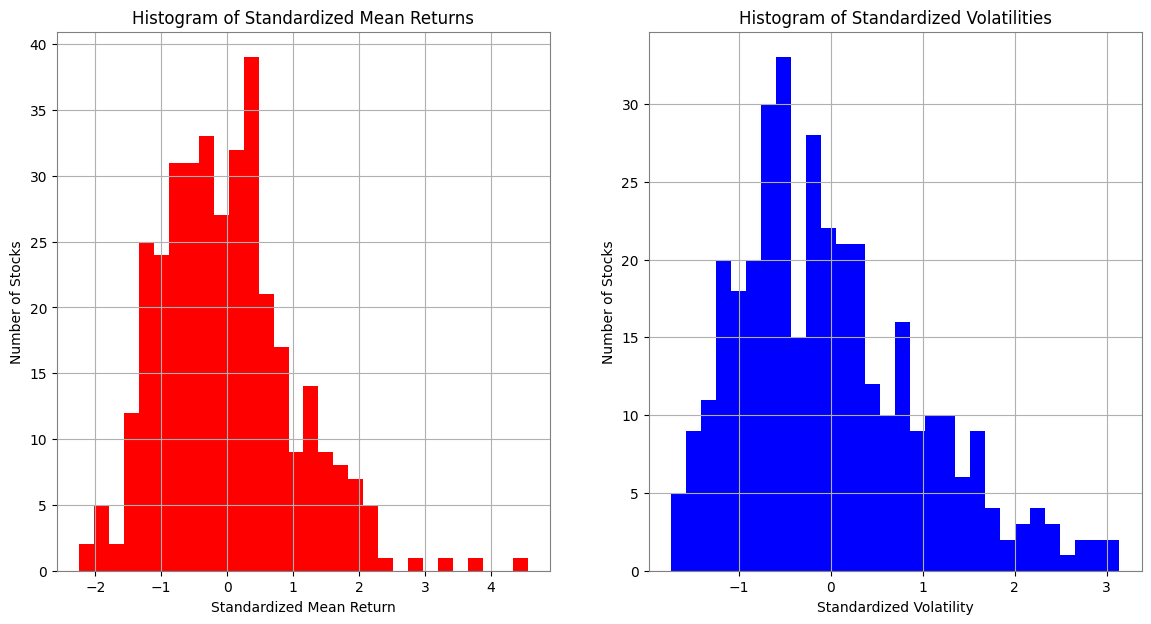

In [25]:
spines = ["bottom", "left", "top", "right"]

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14,7))
ax[0].hist(graph_2_df.returns, bins = 30, color = "red")
ax[0].set_title("Histogram of Standardized Mean Returns")
ax[0].set_xlabel('Standardized Mean Return')
ax[0].set_ylabel('Number of Stocks')
ax[0].grid(None)

for axis in spines:
    ax[0].spines[axis].set_color('Grey') 
ax[1].hist(graph_2_df.volatility, bins = 30, color = "blue")
ax[1].set_title("Histogram of Standardized Volatilities")
ax[1].set_xlabel('Standardized Volatility')
ax[1].set_ylabel('Number of Stocks')
ax[1].grid(None)

for axis in spines:
    ax[1].spines[axis].set_color('Grey') 
plt.show()

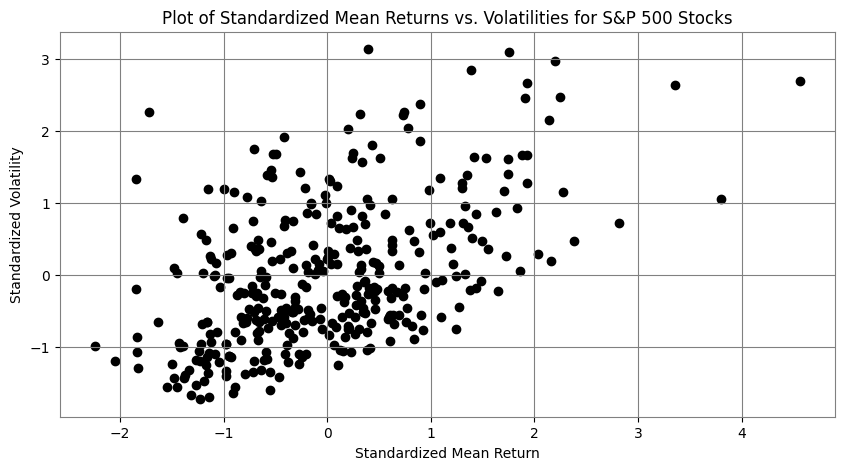

In [26]:
spines = ["bottom", "left", "top", "right"]

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
scatter = ax.scatter(graph_2_df.iloc[:,0],graph_2_df.iloc[:,1], c = "black")
ax.set_title('Plot of Standardized Mean Returns vs. Volatilities for S&P 500 Stocks')
ax.set_xlabel('Standardized Mean Return')
ax.set_ylabel('Standardized Volatility')
ax.grid(color = "Grey")
for axis in spines:
    ax.spines[axis].set_color('Grey') 
plt.show()

<a id='4'></a>
# 4. Evaluate Algorithms and Models

Cluster Analysis is a technique used to group various sets of objects together that share similar characteristics. It has been prominently used in the finance domain by investors to develop a cluster trading approach to help them build a diversified portfolio, helping protect the them against systemic risks that could make the portfolio vulnerable to losses.

It should be noted that there are a number of clustering algorithms that can be used to group data. These methods either differ based on strategic constraints imposed by the end-user, or by the method used to converge towards ideal clusters. When choosing a clustering algorithm, we must consider whether the algorithm scales to the dataset. Datasets in machine learning can have millions of examples, but not all clustering algorithms scale efficiently. For an exhaustive list see [A comprehensive survey of clustering algorithms](https://doi.org/10.1007/s40745-015-0040-1)

However, in order to evaluate the performance of a clustering algorithm, a **silhouette score** must be utilized to calculate the discreteness of formed clusters.

In this pair trading strategy, we explore three different clustering techniques used to identify different clusters of stocks that minimize the amount of intra-stock correlation. Silhouette scores are compared across all three techniques, and the clustering method yielding the with highest score is selected for further analysis. Optimal pairs will then be generated in **Section 7** within each cluster by applying an Augmented Dickey Fuller cointegration test.

We will look at the following models:

1. **KMeans**
2. **Hierarchical Clustering** (Agglomerative Clustering)
3. **Affinity Propagation** 

<HR>

<a id='5.1'></a>
## 4.1. K-Means Clustering

The **K-Means Clustering** algorithm is an iterative algorithm that partitions the datasets into $k$-distinct non-overlapping clusters where each datapoint belongs exactly to one cluster. It attempts to cluster points together based on greatest similarity (homogeneity), while also maximizing the distance between each individual cluster.


One of the major challenges in applying a K-Means Clustering algorithm is the selection of an optimal value of $k$. Choosing the right value of $k$ is crucial, as it can impact the performance of the model.There are several methods to determine the optimal $k$ using K-Means Clustering:<BR>
+ **Supervised Methods** - can be used when we have external information about the data. This is equivalent to knowing the actual ground truth of how clusters are formed in reality.
+ **Unsupervised Methods** - These methods are based on parameters that are intrinsic to the dataset, and don’t need any external validation from empirical sources.

### Supervised K-Means Method

To properly survey the landscape for K-Means clustering using a supervised approach, an initial value of $k$ must be selected to see how clusters form. 

In this section, a supervised model with 10 clusters is created using the `KMeans` module from the `sklearn.cluster` package. Once an instance of a K-Means model is generated from a `KMeans` class, the instance can call a `predict` function to get cluster predictions for each data point.

In [27]:
n_clusters = 10
random_state = 10

# Algorithm:
# 1. Randomly pick k centroids from the examples ploted above as initial cluster centers (𝜇𝑗,𝑗∈1,...,𝑘)
# 2. Assign each example to the nearest centroid,  𝜇𝑗
# 3. Move the centroids to the center of the examples that were assigned to it
# 4. Repeat (2-3) until the cluster assignments do not change or a maximum number of iterations is reached.

def fit_kmeans(X, n_clusters, random_state):

    kmeans = KMeans(n_clusters=n_clusters,
                    init='k-means++',
                    n_init=10,
                    max_iter=300,
                    tol=1e-04)
    model = kmeans.fit(X)
    return model

model = fit_kmeans(X, n_clusters, random_state)
print(model)

## get cluster prediction and add to DataFrame
kX = X.copy()
kX['cluster'] = model.predict(X)
kX

KMeans(n_clusters=10, n_init=10)


returns  volatility  cluster
Ticker                              
A         0.035       0.722        0
AAPL      2.380       0.467        8
ABT      -0.581      -1.176        1
ACGL      0.837      -0.892        4
ADBE      1.434       0.842        8
...         ...         ...      ...
XOM      -1.123      -0.930        7
XRAY     -0.678      -0.810        1
YUM       0.211      -0.742        4
ZBRA      0.372       0.354        0
ZION     -0.900       1.151        3

[358 rows x 3 columns]

<Figure size 1500x500 with 0 Axes>

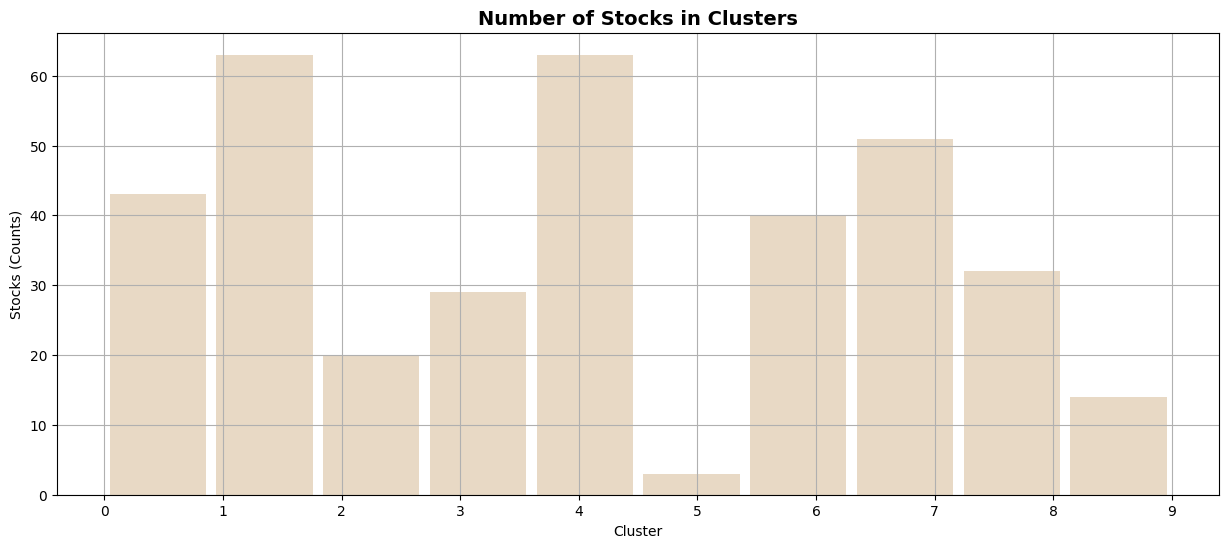

In [28]:
## plot histogram and print out number of points in each color cluster

fig = plt.figure(figsize=(15, 5))
kX.hist(column='cluster', grid=True, figsize=(15,6), color='tan', alpha=0.5, rwidth=0.9)
plt.title("Number of Stocks in Clusters", fontsize=14, color="black", fontweight="bold")
plt.xlabel("Cluster")
plt.ylabel("Stocks (Counts)")
plt.xticks([i for i in range(0, 10)])
plt.show()

### K-Means Unsupervised Methods

Contrary to the supervised approach depicted above, which naively prescribes a value of $k=10$, two different methods will be used for the unsupervised approach:<BR>
+ **The Elbow Method**<BR>
    The elbow method plots the value of inertia produced by different values of $k$. The value of inertia will decline as $k$ increases.<BR>
    The elbow method is used to iterate through the values of k and calculate both the distortion for each value of $k$, as well as the distortion and inertia for each value of $k$ in the specified range. Here, distortion is defined as the average of the squared distances of each feature to the closest cluster center.<BR>
    The idea here is to choose a value of $k$ after whereby the rate of decrease of the inertia converges to a threshold value. <BR><BR>
+ **The Silhouette Method**<BR>
    The silhouette coefficient combines the concepts of cluster cohesion and cluster separation.<BR>
    The range of the silhouette value is between +1 and -1. A high value is desirable and indicates that the point is placed in the correct cluster. If many points have a negative Silhouette value, it may indicate that we have created too many, or too few, clusters.<BR>
    We use Silhouette method to reaffirm the optimal number of clusters ($k$). The K-Means clustering model is trained using the found optimal $k$ value to generate clusters for our pair selection.

#### The Elbow Method

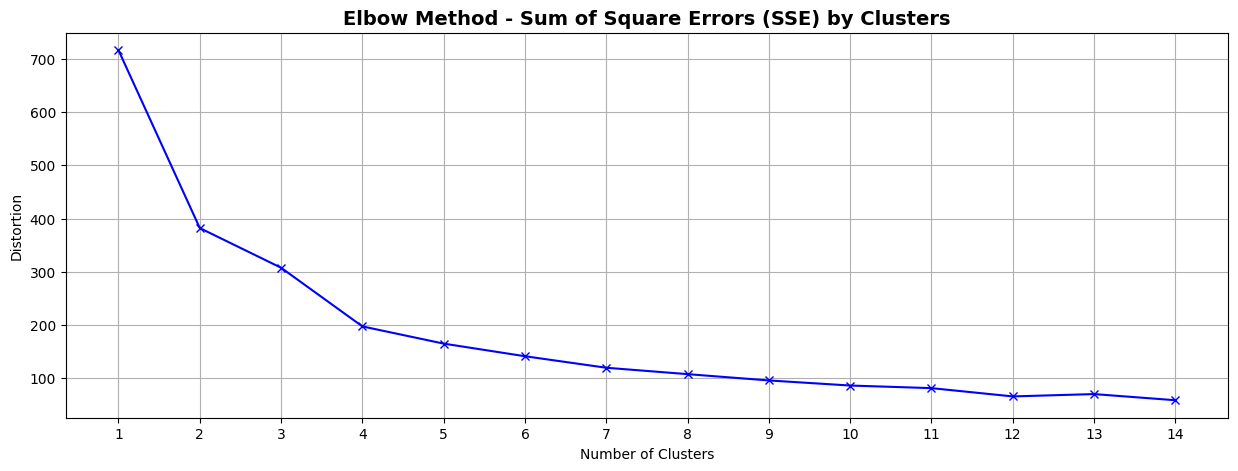

In [29]:
# The Elbow Method

distortions = []
max_loop = 15
sse = {}

for k in range(1, max_loop):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)
    sse[k] = kmeans.inertia_

fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, max_loop), distortions, 'bx-')
plt.title("Elbow Method - Sum of Square Errors (SSE) by Clusters", fontsize=14, color="black", fontweight="bold")
plt.xticks([i for i in range(1, max_loop)], rotation=0)
plt.xlabel("Number of Clusters")
plt.ylabel("Distortion")
plt.grid(True)

We can see that after the 5th cluster, the inertia does not decrease at a significant rate. Therefore, using this method, we can say that $k=5$ is a good choice for the number of clusters.<BR>
    
We can confirm this by feeding mean return and volatility data into the `KneeLocator` class, which detects when asymptotic convergence reaches a specific threshold. An instance of `KneeLocator` is created by this process, whereby the `elbow` property can be called to determine at what value of $k$ convergence has reached threshold.


In [30]:
kn = KneeLocator(x=list(sse.keys()), 
                 y=list(sse.values()), 
                 curve='convex', 
                 direction='decreasing')
print('Suggested number of clusters: ', kn.elbow)

Suggested number of clusters:  4


<HR>

#### The Silhouette Method

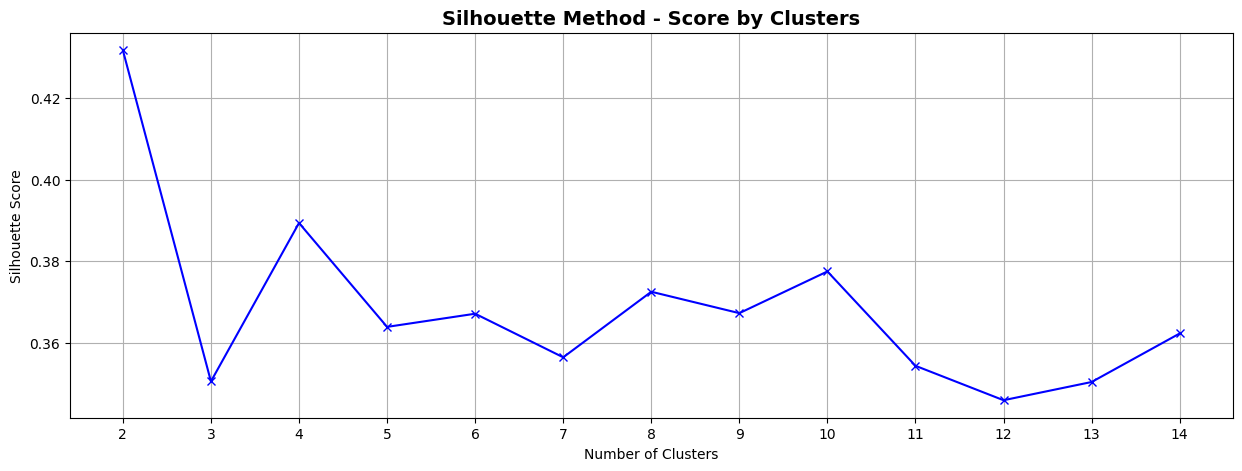

In [31]:
# The Silhouette Method:

#For the silhouette method k needs to start from 2

silhouette_score = []
max_loop = 15
sse = {}

for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='random')
        kmeans.fit(X)        
        silhouette_score.append(metrics.silhouette_score(X, kmeans.labels_))
        sse[k] = kmeans.inertia_
        
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), silhouette_score, 'bx-')
plt.title("Silhouette Method - Score by Clusters", fontsize=14, color="black", fontweight="bold")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks([i for i in range(2, max_loop)], rotation=0)
plt.grid(True)

A high silhouette score is desirable. The silhouette score reaches its absolute maximum at the optimal k. This should ideally appear as a peak in the silhouette value-versus-k plot.

Visualizing the plot alone, it seems that when $k=6$, the score reaches its peak value. We can confirm the optimal silhouette score at the optimal k by creating another `KneeLocator` instance, and extracting the `knee` property. 

The Elbow Method is more of a decision rule, while the Silhouette is a metric used for validation while clustering. This means that it can be used in combination with the Elbow Method.

Therefore, the Elbow Method and the Silhouette Method are not alternatives to each other for finding the optimal K. Rather they are tools to be used together for a more confident decision.


In [32]:
kn = KneeLocator(x=list(sse.keys()), 
                 y=list(sse.values()), 
                 curve='convex', 
                 direction='decreasing')

print('Suggested number of clusters based on knee score: ', kn.knee)

Suggested number of clusters based on knee score:  6


#### Our decision then is to use $k=6$ as the optimal number of clusters.
<HR>

### Fit model and create predictions

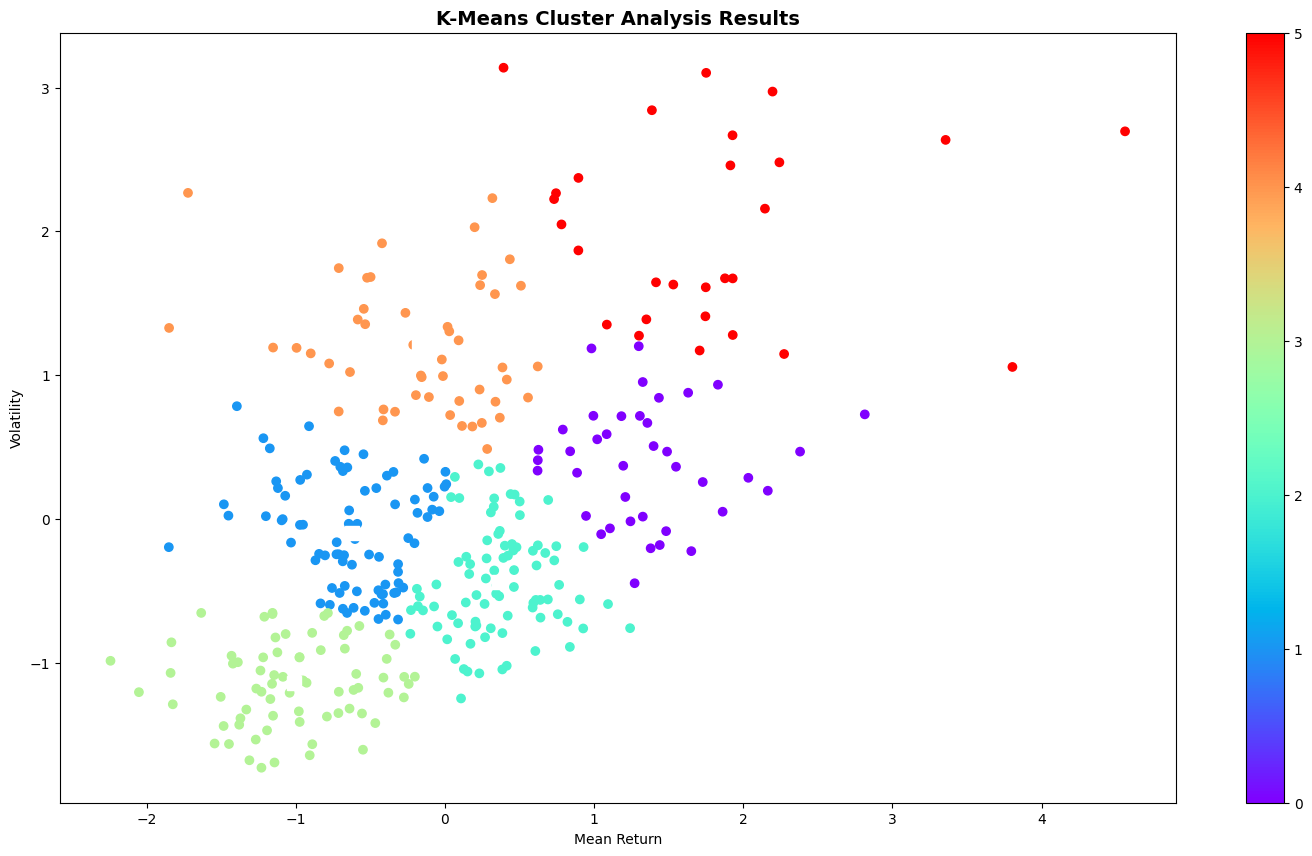

In [33]:
c = kn.knee   # Number of clusters

#Fit the model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(X)

#Plot the results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c=k_means.labels_, cmap="rainbow", label = X.index)
ax.set_title('K-Means Cluster Analysis Results', fontsize=14, color='black', fontweight='bold')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'sw',markersize=10)
plt.show()

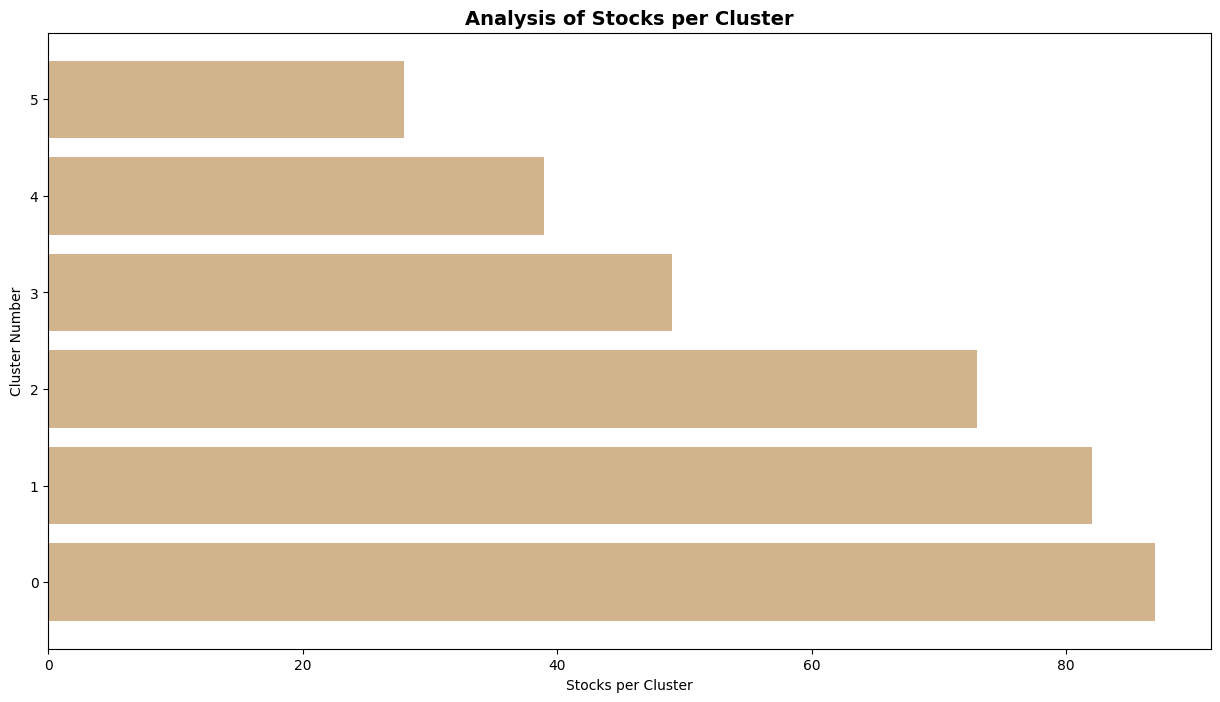

In [34]:
# Plot number of stocks per cluster

clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
plt.figure(figsize=(15,8))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts(), color='tan')
plt.title('Analysis of Stocks per Cluster', fontsize=14, color="black", fontweight="bold")
plt.xlabel('Stocks per Cluster')
plt.ylabel('Cluster Number')
plt.show()


In [35]:
counts = clustered_series.value_counts()

cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

clust1 = pd.DataFrame(clustered_series,columns=['label'])
grouped_df = clust1.groupby('label')

<a id='7'></a>
# 6. Spread Forecasting

Now that optimal trading pairs have been selected using the CDFT, these pairs can now be applied in forecasting. To satisfy audience familiarity and amusement, the following optimal trading pair will be used to forecast closing prices:

`Stock 1 (P1) = AMD` $:$ `Stock 2 (P2) = TSLA`

Which corresponds to Advanced Micro Devices and Tesla.

The `create_timeseries()` function pulls out features from any specified pair of stocks and creates a timeseries object out of these columns. The features of each stock are extracted into separate dataframes, and each feature name is suffixed by `P1` or `P2`, respectively, to preserve each stock's identity. The newly-suffixed dataframes are then merged along `Date` to create a single, wide-format dataframe. 

The spread over time of each object will be plotted, with the goal of demonstrating similarity in forecasting behavior between these stocks. 

In [36]:
final_data['Symbol'] = final_data['Ticker']

In [37]:
def create_timeseries(final_data, P1_name, P2_name):

    cols = final_data.columns.drop(['GICS Sector', 'GICS Sub-Industry', 'Symbol'])
    
    # subset the original data for the selected pair
    P1_data = final_data[final_data['Symbol']==P1_name][cols]
    P2_data = final_data[final_data['Symbol']==P2_name][cols]

    # rename columns to identify the features 
    P1_data.columns = ['P1_' + s for s in cols]
    P2_data.columns = ['P2_' + s for s in cols]

    # merge both the data on Date to create a single time series wide format data
    pair_data = pd.merge(P1_data, P2_data, left_on='P1_Date', right_on='P2_Date')
    pair_data.index = pair_data['P1_Date']
    del pair_data['P2_Date']
    del pair_data['P1_Date']
    return pair_data

In [38]:
[c for c in final_data if 'return' in c.lower()]

['daily_returns']

In [39]:
P1 = 'AMD'  # Advanced Micro Devices
P2 = 'TSLA'  # Tesla
pair_data = create_timeseries(final_data, P1, P2)
pair_data.head()

P1_Open  P1_High  P1_Low  P1_Close  P1_Adj Close    P1_Volume  \
P1_Date                                                                     
2010-06-29    7.930    7.930   7.410     7.480         7.480 43861400.000   
2010-06-30    7.580    7.650   7.300     7.320         7.320 26406200.000   
2010-07-01    7.350    7.530   7.100     7.390         7.390 27289900.000   
2010-07-02    7.450    7.480   7.020     7.170         7.170 26074800.000   
2010-07-06    7.400    7.420   6.960     7.040         7.040 25868800.000   

           P1_Ticker  P1_rsi  P1_kama         P1_adi  ...         P2_vpt  \
P1_Date                                               ...                  
2010-06-29       AMD  34.506    8.683 5394916088.355  ... 7818633941.547   
2010-06-30       AMD  32.720    8.610 5371527737.728  ... 7817986466.127   
2010-07-01       AMD  34.321    8.537 5381047439.320  ... 7808312190.317   
2010-07-02       AMD  31.763    8.388 5371977953.069  ... 7798622402.540   
2010-07-06       AMD  30.325    7.942 5355106987.220  ... 7782045278.767   

            P2_atr  P2_bb_ma  P2_adx  P2_ema  P2_macd   P2_dlr  \
P1_Date                                                          
2010-06-29   9.945    96.647  41.547  91.292   -2.760 -422.152   
2010-06-30   9.268    92.069  44.337  79.331   -8.755   -0.251   
2010-07-01   8.633    87.580  46.930  68.949  -13.549   -8.172   
2010-07-02   8.037    83.083  49.339  59.926  -17.332  -13.431   
2010-07-06   7.483    78.506  51.579  52.079  -20.264  -17.547   

            P2_daily_returns  P2_50 Days Average  P2_200 Days Average  
P1_Date                                                                
2010-06-29            -0.985              92.040               99.842  
2010-06-30            -0.003              90.239               99.327  
2010-07-01            -0.078              88.452               98.803  
2010-07-02            -0.126              86.647               98.280  
2010-07-06            -0.161              84.913               97.765  

[5 rows x 40 columns]

In [40]:
pair_data[['P1_daily_returns','P2_daily_returns']].describe(np.arange(0,0.9,0.1).tolist()+np.arange(0.9,1,0.01).tolist())

P1_daily_returns  P2_daily_returns
count          3400.000          3400.000
mean              0.001             0.002
std               0.036             0.040
min              -0.242            -0.985
0%               -0.242            -0.985
10%              -0.035            -0.036
20%              -0.021            -0.021
30%              -0.013            -0.011
40%              -0.006            -0.004
50%               0.000             0.001
60%               0.007             0.007
70%               0.015             0.015
80%               0.024             0.024
90%               0.039             0.040
91%               0.041             0.042
92%               0.043             0.045
93%               0.048             0.048
94%               0.052             0.051
95%               0.056             0.057
96%               0.062             0.063
97%               0.070             0.073
98%               0.080             0.085
99%               0.107             0.110
max               0.523             0.244

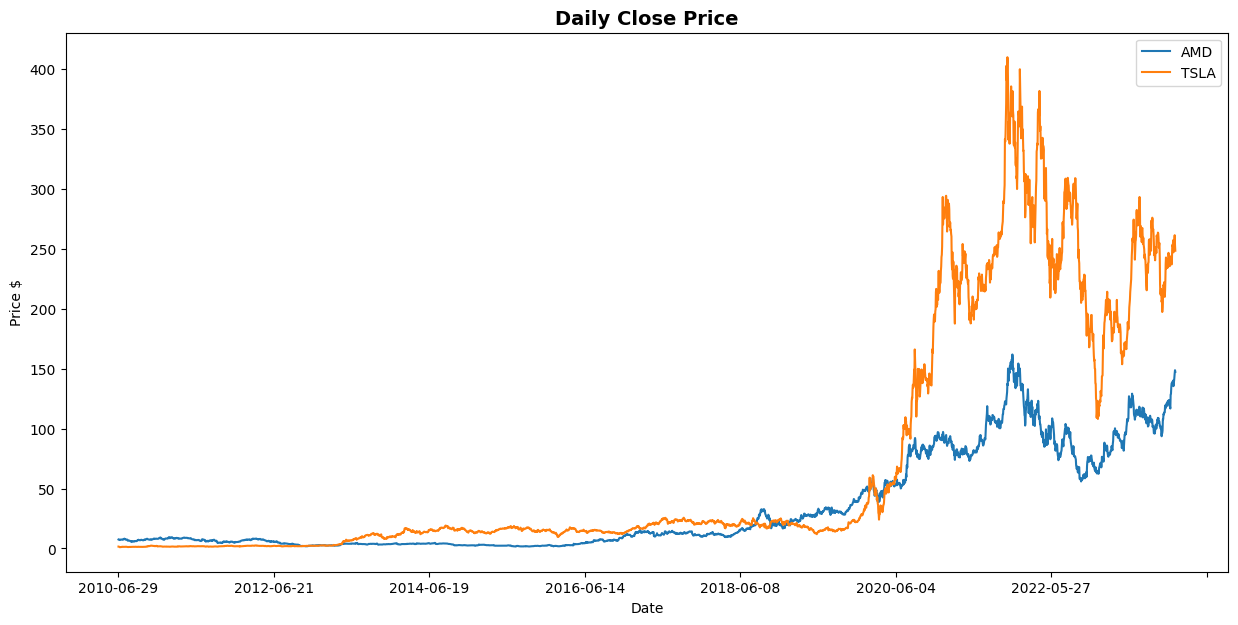

In [41]:
pair_data['P1_Close'].plot(figsize=(15,7), legend = True, label = "AMD")
pair_data['P2_Close'].plot(figsize=(15,7), legend = True, label = "TSLA")
plt.ylabel('Price $')
plt.xlabel('Date')
plt.title('Daily Close Price', fontsize=14, color="black", fontweight="bold")
plt.show()

### Ground Truth Spread

Given that highly co-integrated trading pairs typically share a baseline minimal deviation in closing prices from each other, the assumption holds that if deviations in closing prices are observed, then those deviations are highly likely to return back to baseline. This means that deviations in stock closing prices can be framed as investment opportunities.

By forecasting the spread between two stocks over time, a strategy can be used to measure the divergence in spread between stocks in a trading pair, and determines whether to open or close a position. An open position is advised when the spread diverges from 0 with the hope that the spread will converge back to its mean difference which of 0.

The `ground_spread()` function is used to run a linear regression of $ log(p_1) = \beta X log(p_2) + \varepsilon$, where $p_1$ and $p_2$ are daily closing prices of the stocks `P1` and `P2`, the coefficient $\beta$ is the cointegration coefficient, and the stochastic term $\varepsilon$ is the spread attributed to error between those closing prices.

In [42]:
def ground_spread(pair1, pair2):
    est = est = sm.OLS(pair1, pair2)
    est = est.fit()
    beta = -est.params[0]
    print(beta)
    return pair1 + (pair2 * beta)

In [43]:
def acc_metric(true_value, predicted_value):
    acc_met = 0.0
    m = len(true_value)
    for i in range(m):
        acc_met += mean_squared_error(true_value, predicted_value)
    acc_met /= m
    return np.sqrt(acc_met)

-0.3067103744892137


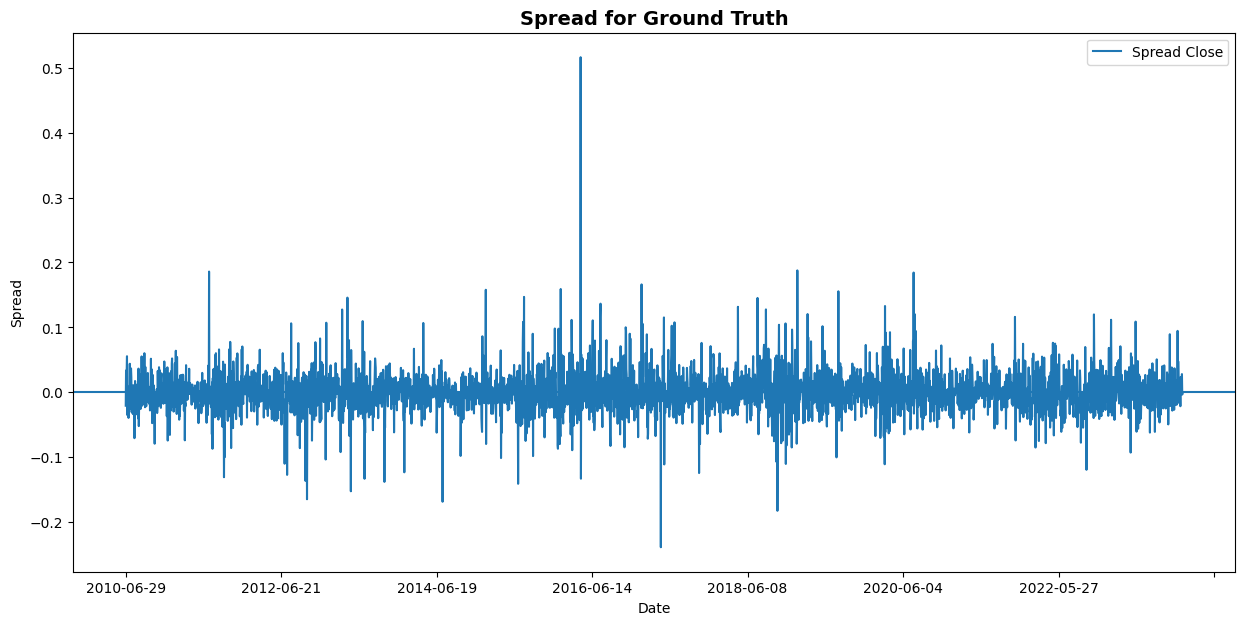

In [44]:
# Calculate the spread between close prices of both stocks
pair_data['Spread_Close'] = ground_spread(pair_data.P1_daily_returns.shift(-1).fillna(0), pair_data.P2_daily_returns.shift(-1).fillna(0))
pair_data['Spread_Close'].plot(figsize=(15,7))
plt.axhline(pair_data['Spread_Close'].mean())
plt.title('Spread for Ground Truth', fontsize=14, color="black", fontweight="bold")
plt.ylabel('Spread')
plt.xlabel('Date')
plt.legend(['Spread Close'])
plt.show()

In [45]:
# Calculate the spread for open prices of both stocks
pair_data['Spread_Open'] = ground_spread(pair_data.P1_Open, pair_data.P2_Open)

# Calculate the spread for high prices of both stocks
pair_data['Spread_High'] = ground_spread(pair_data.P1_High, pair_data.P2_High)

# Calculate the spread for low prices of both stocks
pair_data['Spread_Low'] = ground_spread(pair_data.P1_Low, pair_data.P2_Low)

-0.4054256433949684
-0.40464614873784094
-0.4067930770327775


#### Preprocessing Data

In order to accurately predict future data from this time series object, historical data within a specific timeframe must be examined to determine the next appropriate step towards the future. The process of "looking back" means that new data must be created based on data some number of steps beforehand. 

Training, validation and test sets will be constructed to determine the effectiveness of closing price predictions. Each of these datasets will include data generated by timeseries predictions. This data will then be utilized in three forms of time series analysis:

- Autoregressive Integrated Moving Average (ARIMA)
- Kalman Filtering
- Long Short Term Memory (LSTM)

Descriptions for these TSA methods will be described in subsequent sections.

In [46]:
# Establish lengths for the training, validation and test sets.
train_size = int(len(pair_data) * 0.7)
val_size = int((len(pair_data) - train_size) * 0.5) - 30
test_size = len(pair_data) - train_size - val_size

# Split the data into training, validation and test sets based on these lengths:
train, val, test = pair_data[0:train_size], pair_data[train_size:train_size + val_size], pair_data[train_size + val_size:len(pair_data)]
print(f"The length of the training set is: {len(train)}.\nThe length of the validation set is: {len(val)}.\nThe length of the test set is: {len(test)}.")

The length of the training set is: 2380.
The length of the validation set is: 480.
The length of the test set is: 540.


In [47]:
def ground_spread(pair1, pair2):
    est = est = sm.OLS(train.P1_daily_returns.shift(-1).fillna(0), train.P2_daily_returns.shift(-1).fillna(0))
    est = est.fit()
    beta = -est.params[0]
    print(beta)
    return pair1 + (pair2 * beta)

def ground_spread(pair1, pair2):
    return pair1-pair2

In [48]:
train['Spread_Close'] = ground_spread(train.P1_daily_returns, train.P2_daily_returns)
val['Spread_Close'] = ground_spread(val.P1_daily_returns, val.P2_daily_returns)
test['Spread_Close'] = ground_spread(test.P1_daily_returns, test.P2_daily_returns)

train['next_delta_Spread_Close'] = train['Spread_Close'].shift(-1).fillna(0) - train['Spread_Close']
val['next_delta_Spread_Close'] = val['Spread_Close'].shift(-1).fillna(0) - val['Spread_Close']
test['next_delta_Spread_Close'] = test['Spread_Close'].shift(-1).fillna(0) - test['Spread_Close']

train = train[:-1]
val = val[:-1]
test = test[:-1]

In [49]:
# Define a function that creates datasets including look-back data.
def create_dataset(dataset, look_back=1):
#     dataX, dataY = [], []
#     for i in range(len(dataset) - look_back):
#         a = dataset.drop('delta_Spread_Close',axis=1).iloc[i]
#         dataX.append(a)
#         dataY.append(dataset.iloc[(i+1):(i+1+look_back)]['delta_Spread_Close'])
    dataX = dataset.drop('next_delta_Spread_Close',axis=1)
    dataY = dataset['next_delta_Spread_Close']
    return dataX, scaler.fit_transform(dataX), dataY, scaler.fit_transform([dataY.values]).flatten()

In [50]:
# Creating data for look back period of S_t -1 and performing train_test split
look_back = 1
scaler = MinMaxScaler(feature_range=(0, 1))

columns_to_drop = ['P1_Ticker','P2_Ticker','Spread_Open','Spread_High','Spread_Low']
# Generate dataset for trainX, trainY, testX, testY
X_train_unorm, X_train, Y_train_unorm, Y_train = create_dataset(train.drop(columns_to_drop,axis=1), look_back)
X_val_unorm, X_val, Y_val_unorm, Y_val = create_dataset(val.drop(columns_to_drop,axis=1), look_back)
X_test_unorm, X_test, Y_test_unorm, Y_test = create_dataset(test.drop(columns_to_drop,axis=1), look_back)

### Long Short Term Memory (LSTM)

After testing the data on traditional timeseries models, we now examine a state-of-the-art **Long Short Term Memory (LSTM)** neural network architecture to forecast closing prices between trading pairs.

LSTM models are capable of learning long term dependencies. These models exercise "short term memory" by allowing information from each individual training phase to inform training performance, and likewise utilize "long term memory" by iteratively reconfiguring weights and biases after repeat training phases. This means that these models are flexible enough to fit to specific iterations of training data, but likewise refer to weights and biases accumulated from previous training data phases to fit to broader trends. 

The architecture in this strategy consists of 2 stacked LSTM neural layers, followed by fully interconnected internal layers, in a `lstm` class object.

In [51]:
#Creating the LSTM model
class lstm(Model):
    def __init__(self, in_shape, look_back):
        super(lstm, self).__init__()
        self.shape = in_shape
        self.look_back = look_back
        self.lstm_l1 = LSTM(256, input_shape=self.shape, return_sequences = True)
#         self.lstm_l2 = LSTM(256)
        self.dropout = Dropout(0.2)
        self.dense = Dense(self.look_back)

    def call(self, x):
        x = self.lstm_l1(x)
#         x = self.lstm_l2(x)
        x = self.dropout(x)
        x = self.dense(x)
        return x

In [52]:
# Reshape X for model training
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
valX = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [53]:
trainX_without_max_y = np.delete(trainX, (Y_train_unorm.reset_index().next_delta_Spread_Close.idxmax()), axis=0)
Y_train_unorm_without_max_y = Y_train_unorm.drop(Y_train_unorm.idxmax(),axis=0)

In [54]:
#initializing the lstm model
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3,\
                                            min_delta=0.001,restore_best_weights=True,verbose=1)

lstm_model = lstm((trainX.shape[1], trainX.shape[2]), look_back = 1)
lstm_model.compile(loss='mae', 
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), metrics=['mae'])
#fitting the model
history = lstm_model.fit(
                    trainX_without_max_y, 
                    Y_train_unorm_without_max_y, 
                    epochs=20, 
                    batch_size=32,
                    validation_data=(valX, Y_val_unorm), 
                    verbose=1, 
                    callbacks=callback,
                    shuffle=True)

Epoch 1/20


2024-02-11 20:59:22.391259: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


75/75 [==============================] - 2s 7ms/step - loss: 0.0892 - mae: 0.0892 - val_loss: 0.0455 - val_mae: 0.0455
Epoch 2/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0436 - mae: 0.0436 - val_loss: 0.0466 - val_mae: 0.0466
Epoch 3/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0432 - mae: 0.0432 - val_loss: 0.0449 - val_mae: 0.0449
Epoch 4/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0425 - mae: 0.0425 - val_loss: 0.0460 - val_mae: 0.0460
Epoch 4: early stopping


In [55]:
lstm_model.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               multiple                  303104    
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  257       
                                                                 
Total params: 303361 (1.16 MB)
Trainable params: 303361 (1.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


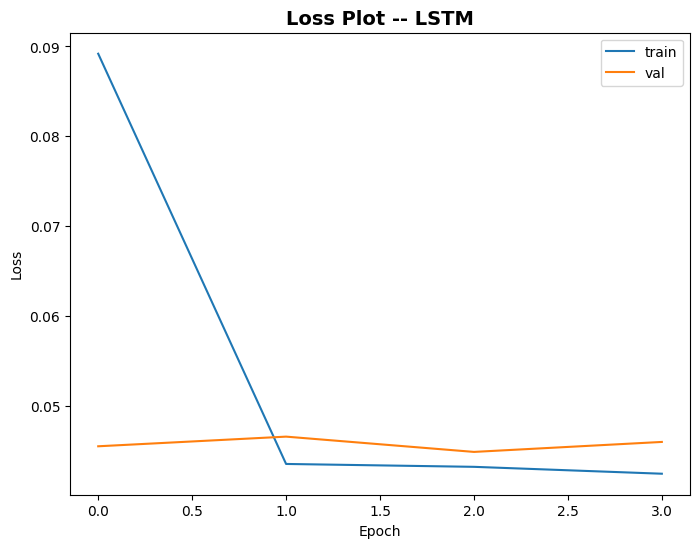

In [56]:
# Plot line graph to show amount loss according the the epoch
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss Plot -- LSTM', fontsize=14, color="black", fontweight="bold")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [57]:

plot_df = pd.DataFrame({'Date':test.index,
                        'True Value':test['Spread_Close']+test['next_delta_Spread_Close'],
                        'Predicted Value -- LSTM':lstm_model.predict(testX).flatten()+test['Spread_Close']})
fig = px.line(plot_df, x='Date', y=['True Value','Predicted Value -- LSTM'],title='LSTM vs True')
fig.show()

17/17 [==============================] - 0s 865us/step


In [58]:
AR1_mae = (X_test_unorm['Spread_Close'] - X_test_unorm['Spread_Close'].shift(-1)).abs().mean()
AR1_mae

0.03951816453265812

In [59]:
lstm_mae = (lstm_model.predict(testX).flatten() - Y_test_unorm).abs().mean()
lstm_mae

17/17 [==============================] - 0s 976us/step


0.03958424248794262

In [60]:
scaled_error = lstm_mae/AR1_mae
scaled_error

1.0016720906971754

In [61]:
# # Scaler Inverse Y back to normal value
# yhat_LSTM = lstm_model.predict(testX)
# # Y_test_LSTM = scaler.inverse_transform(Y_test)
# Y_test_LSTM = Y_test_unorm

# # Training and Test error
# mse_LSTM_train = acc_metric(Y_train_unorm, lstm_model.predict(trainX))
# mse_LSTM_test = acc_metric(yhat_LSTM, Y_test_LSTM)
# # print('LSTM MSE: ')
# # print('Train-- ', mse_LSTM_train)
# # print('Test-- ', mse_LSTM_test)

# GBM

In [62]:
import lightgbm as lgb

In [63]:
lgb.__version__

'4.3.0'

In [64]:
final_data.shape

(2701712, 24)

In [65]:
hyper_params = {
#     'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'mae',
    'metric': ['l1'],
#     'eval_metric': ['l1'],
#     'early_stopping_rounds':10,
#     'learning_rate': 0.0001,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.7,
#     'bagging_freq': 10,
    'verbosity': 1,
#     "max_depth": 8,
#     "num_leaves": 128,  
#     "max_bin": 512,
    "num_iterations": 200,
    "importance_type":"gain"
#     "silent":False
}

In [66]:
gbm = lgb.LGBMRegressor(**hyper_params)
callbacks = [\
#             lgb.early_stopping(stopping_rounds=10, verbose=1,min_delta=0.001,first_metric_only=False), 
             lgb.log_evaluation(period=1)]

gbm.fit(X_train_unorm,Y_train_unorm, 
        eval_set=[(X_val_unorm, Y_val_unorm )],
#         eval_metric='l1',
        callbacks=callbacks
       )

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9945
[LightGBM] [Info] Number of data points in the train set: 2379, number of used features: 39
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.000197
[1]	valid_0's l1: 0.0438246
[2]	valid_0's l1: 0.0424643
[3]	valid_0's l1: 0.0410167
[4]	valid_0's l1: 0.0400183
[5]	valid_0's l1: 0.0388378
[6]	valid_0's l1: 0.0377886
[7]	valid_0's l1: 0.0371483
[8]	valid_0's l1: 0.0365907
[9]	valid_0's l1: 0.0361224
[10]	valid_0's l1: 0.0356794
[11]	valid_0's l1: 0.0354391
[12]	valid_0's l1: 0.0352772
[13]	valid_0's l1: 0.0349891
[14]	valid_0's l1: 0.0346396
[15]	valid_0's l1: 0.0345373
[16]	valid_0's l1: 0.0343499
[17]	valid_0's l1: 0.0342589
[18]	valid_0's 

LGBMRegressor(importance_type='gain', metric=['l1'], num_iterations=200,
              objective='mae', verbosity=1)

In [67]:
# # Predictions on X_test 
# yhat = gbm.predict(X_test)+test['Spread_Close'][:-1]
# plt.figure(figsize=(15,8))
# plt.plot(test['Spread_Close'].shift(-1).fillna(0), label='True Value')
# plt.plot(yhat, label='Predicted Value -- GBM')
# plt.title('Spread true vs predictied -- GBM', fontsize=14, color="black", fontweight="bold")
# plt.xlabel('timestep')
# plt.ylabel('normalized spread')
# plt.legend()
# plt.show()


plot_df = pd.DataFrame({'Date':test.index,
                        'True Value':test['Spread_Close']+test['next_delta_Spread_Close'],
                        'Predicted Value -- GBM':gbm.predict(X_test_unorm).flatten()+test['Spread_Close']})
fig = px.line(plot_df, x='Date', y=['True Value','Predicted Value -- GBM'],title='GBM vs True')
fig.show()

In [68]:
AR1_mae = (X_test_unorm['Spread_Close'] - X_test_unorm['Spread_Close'].shift(-1)).abs().mean()
AR1_mae

0.03951816453265812

In [69]:
gbm_mae = (gbm.predict(X_test_unorm) - Y_test_unorm).abs().mean()
gbm_mae

0.02851074719447099

In [70]:
scaled_error = gbm_mae/AR1_mae
scaled_error

0.7214592967977925

In [71]:
pd.concat([X_test_unorm[['P1_daily_returns','P2_daily_returns','Spread_Close']],Y_test_unorm],axis=1).head()

P1_daily_returns  P2_daily_returns  Spread_Close  \
P1_Date                                                        
2021-11-05            -0.008            -0.006        -0.002   
2021-11-08             0.101            -0.048         0.150   
2021-11-09            -0.008            -0.120         0.112   
2021-11-10            -0.061             0.043        -0.104   
2021-11-11             0.044            -0.004         0.048   

            next_delta_Spread_Close  
P1_Date                              
2021-11-05                    0.152  
2021-11-08                   -0.038  
2021-11-09                   -0.216  
2021-11-10                    0.152  
2021-11-11                   -0.007

In [72]:
importances = gbm.feature_importances_
importances = pd.Series(importances,index=X_train_unorm.columns).sort_values(ascending=True)

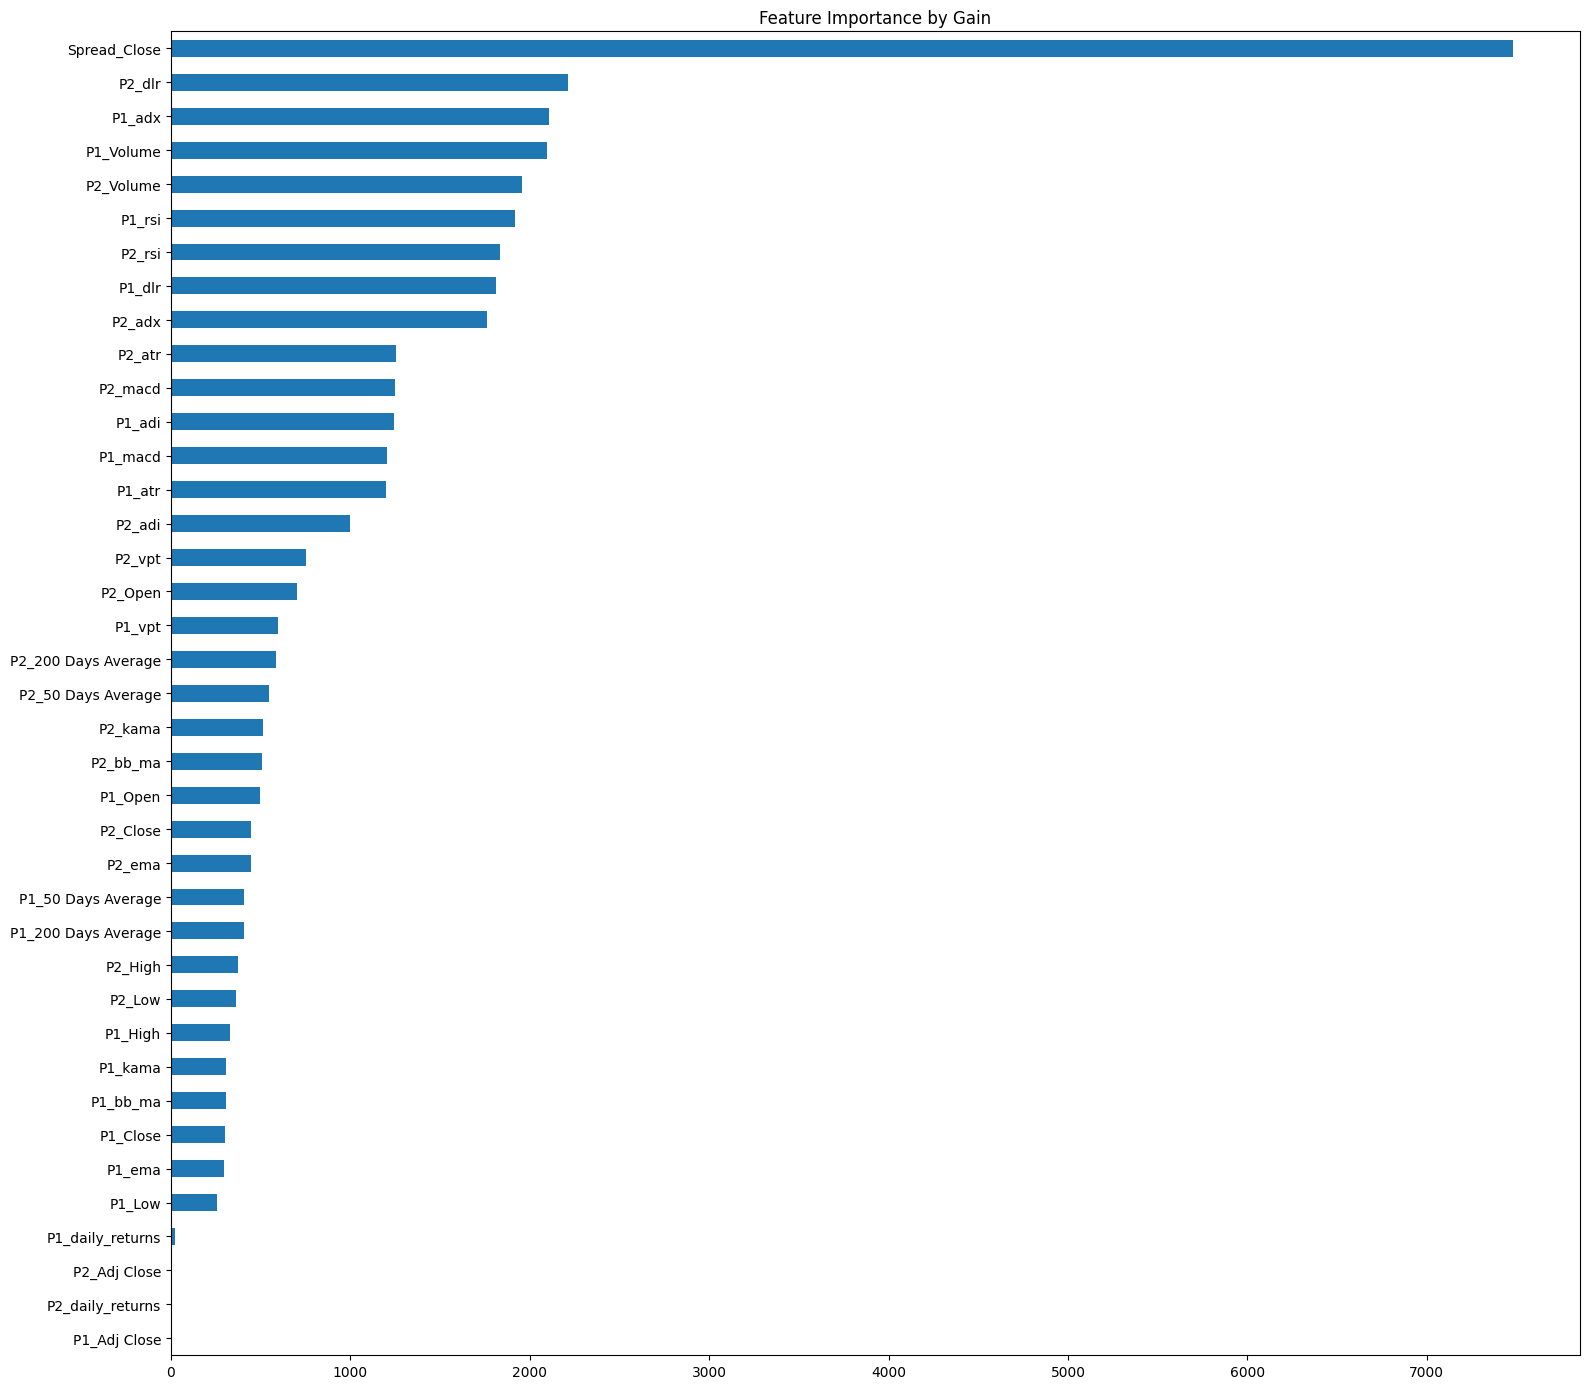

In [73]:
fig,ax=plt.subplots(figsize=[16,14])
importances.plot.barh(ax=ax)
ax.set_title("Feature Importance by Gain")
fig.tight_layout()

<a id='8'></a>
# 7. Developing A Trading Strategy

Time series data from each forecasting algorithm can be used to develop a simple trading strategy to determine when to buy or sell given stocks. 

On a purely applicational level, we track the value of the normalized spread between both stocks in any pair of interest. Once the spread deviates significantly from its baseline value, we can apply the following strategy:

1. A short position is taken for the overvalued stock.
2. A long position in taken for the undervalued stock.

After applying this strategy, PnL (Profit/Loss) estimates can be calcuated to simulate real-world scenarios.

In [74]:
# Test data frame for testing trading strategy
test_data = pd.DataFrame({'P1':pair_data['P1_Close'].iloc[-len(testX):],'P2':pair_data['P2_Close'].iloc[-len(testX):]})
test_data['Actual_Spread'] = pair_data['Spread_Close'].iloc[-len(testX):]
# test_data['Kalman_Predicted_Spread']  = yhat_Kalman
# test_data['ARIMA_Predicted_Spread']  = yhat_ARIMA
# test_data['LSTM_Predicted_Spread'] = list(yhat_LSTM[:,0])
test_data['LSTM_Predicted_Spread'] = lstm_model.predict(testX).flatten()
test_data['GBM_Predicted_Spread'] = gbm.predict(X_test_unorm)

data = test_data['LSTM_Predicted_Spread']

17/17 [==============================] - 0s 878us/step


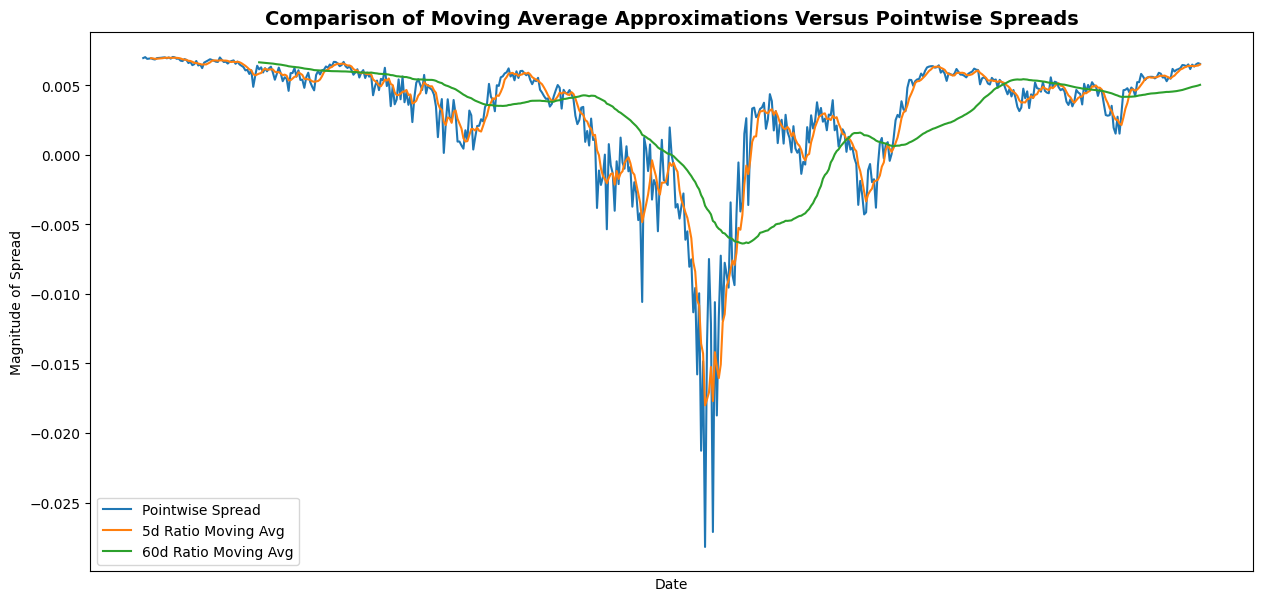

In [75]:
moving_avg_5day= data.rolling(window=5,center=False).mean()

moving_avg_60day = data.rolling(window=60,center=False).mean()

std_60day = data.rolling(window=60,
                        center=False).std()

zscore_60_5 = (moving_avg_5day - moving_avg_60day)/std_60day
plt.figure(figsize=(15,7))
plt.plot(data.index, data.values)
plt.plot(moving_avg_5day.index, moving_avg_5day.values)
plt.plot(moving_avg_60day.index, moving_avg_60day.values)
plt.title("Comparison of Moving Average Approximations Versus Pointwise Spreads",
          fontsize=14, color="black", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Magnitude of Spread")
plt.xticks([])
          
plt.legend(['Pointwise Spread','5d Ratio Moving Avg', '60d Ratio Moving Avg'])

plt.show()

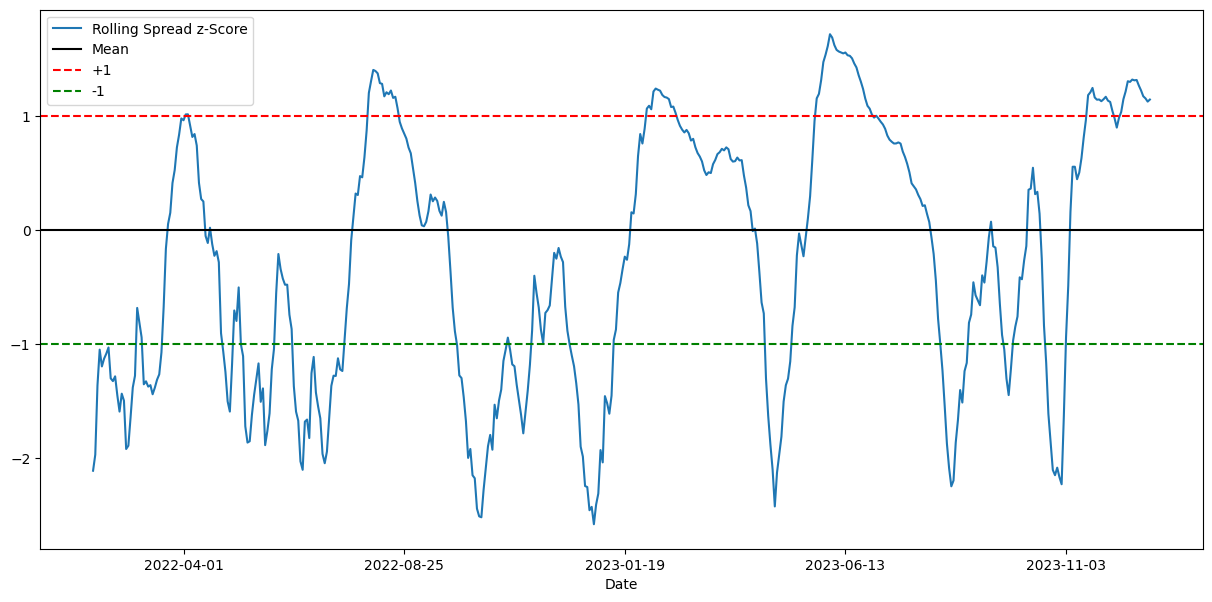

In [76]:
plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Spread z-Score', 'Mean', '+1', '-1'])
plt.xlabel("Date")
plt.show()

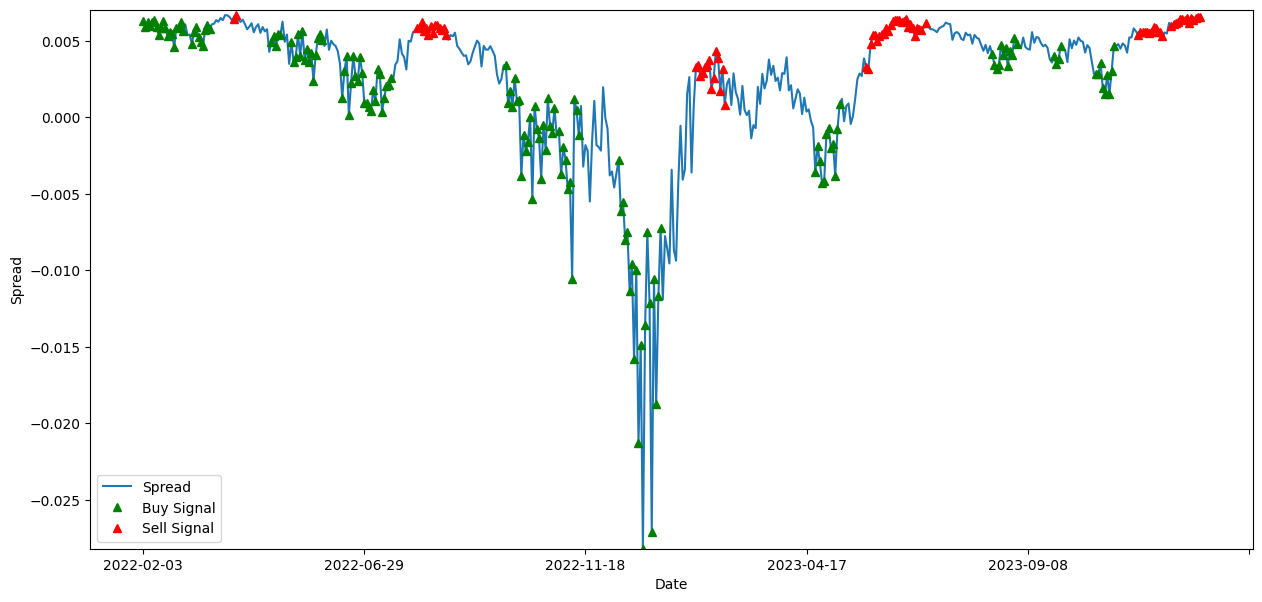

In [77]:
# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))
data[60:].plot()

#separating buy sell signals based on z_scores
buy = data.copy()
sell = data.copy()
buy[zscore_60_5>-1] = -100
sell[zscore_60_5<1] = -100
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,data.min(),data.max()))
plt.legend(['Spread', 'Buy Signal', 'Sell Signal'])
plt.xlabel("Date")
plt.ylabel("Spread")
plt.show()

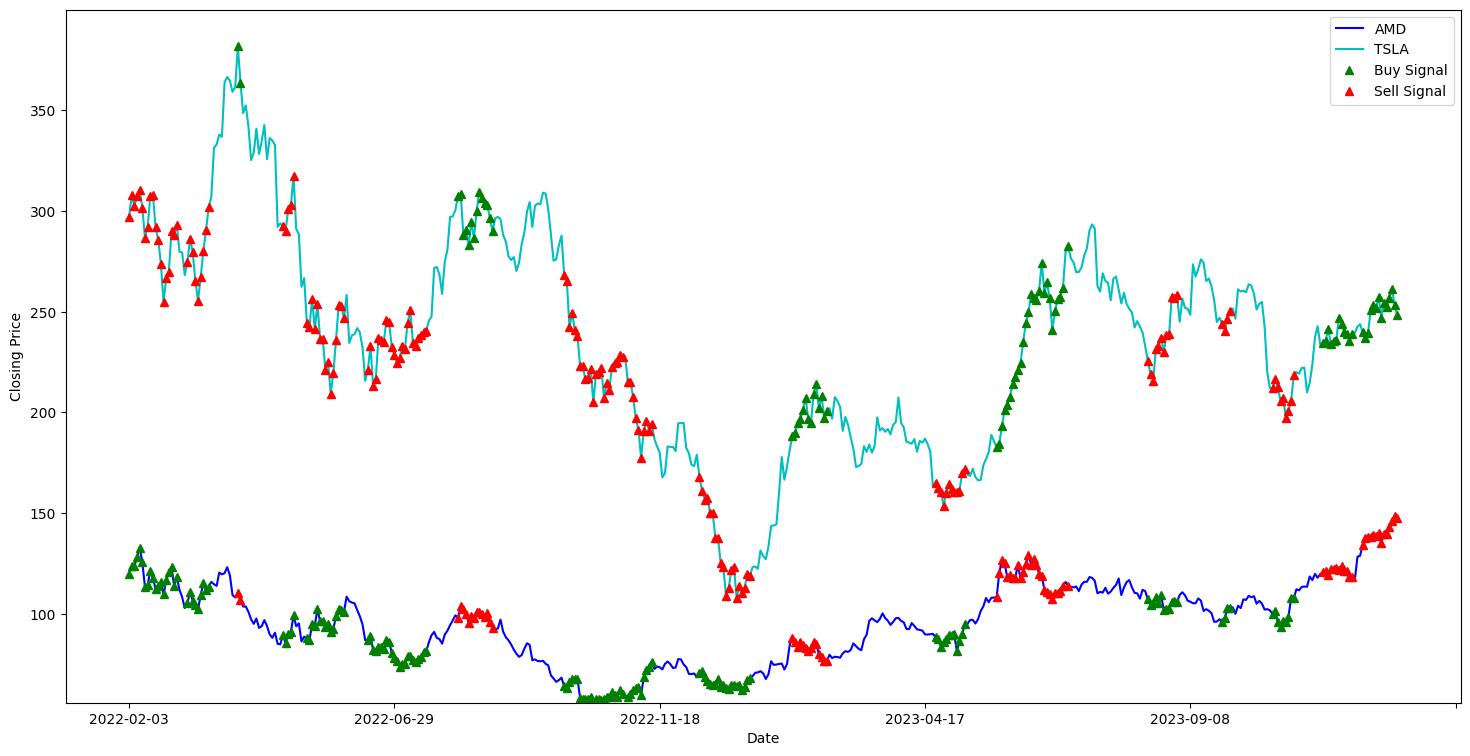

In [78]:
# Plot the prices and buy and sell signals from z score
plt.figure(figsize=(18,9))
P1 = test_data.P1
P2 = test_data.P2

P1[60:].plot(color='b')
P2[60:].plot(color='c')
buyR = 0*P1.copy()
sellR = 0*P1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=-100] = P1[buy!=-100]
sellR[buy!=-100] = P2[buy!=-100]

# When selling the ratio, sell S1 and buy S2 
buyR[sell!=-100] = P2[sell!=-100]
sellR[sell!=-100] = P1[sell!=-100]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(P1.min(),P2.min()),max(P1.max(),P2.max())))

plt.legend(['AMD', 'TSLA', 'Buy Signal', 'Sell Signal'])
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

In [79]:
P1 = test_data.P1
P2 = test_data.P2

buyR = 0*P1.copy()
sellR = 0*P1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=-100] = P1[buy!=-100]
sellR[buy!=-100] = P2[buy!=-100]

# When selling the ratio, sell S1 and buy S2 
buyR[sell!=-100] = P2[sell!=-100]
sellR[sell!=-100] = P1[sell!=-100]

fig = px.line(x=test_data[60:].index, y=[P1[60:].values, P2[60:].values], 
              title='LSTM Model - Buy/Sell signals', 
              labels={'x':'Date', 'value':'Closing Price'})

fig.add_scatter(x=buyR[60:].index, y=buyR[60:].values, mode='markers', marker_color='green', 
                marker_symbol='triangle-up',marker_size=6)
fig.add_scatter(x=sellR[60:].index, y=sellR[60:].values, mode='markers', marker_color='red', 
                marker_symbol='triangle-up',marker_size=6)

# names = cycle(['P1', 'P2', 'Buy Signal', 'Sell Signal'])
fig.update_traces(line=dict(width=2.5))
# fig.update_layout(legend_title="")
fig.update_yaxes(range=[min(P1.min(),P2.min()),max(P1.max(),P2.max())])
fig.update_layout(showlegend=False)
fig.show()

The following profit is estimated when utilizing the advised pair-trading strategy:

In [80]:
def trade(Stock1, Stock2, spread, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    moving_avg1 = spread.rolling(window=window1, center=False).mean()
    moving_avg2 = spread.rolling(window=window2, center=False).mean()
    std = spread.rolling(window=window2, center=False).std()
    zscore = (moving_avg1 - moving_avg2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    trade_count_S1 = 0
    trade_count_S2 = 0
    for i in range(len(spread)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += Stock1[i] - Stock2[i] * spread[i]
            trade_count_S1 -= 1
            trade_count_S2 += spread[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= Stock1[i] - Stock2[i] * spread[i]
            trade_count_S1 += 1
            trade_count_S2 -= spread[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += (trade_count_S1 * Stock1[i]) - (Stock2[i] * trade_count_S2)
            trade_count_S1 = 0
            trade_count_S2 = 0
    return money

In [82]:
data = test_data['GBM_Predicted_Spread'] 
profit = trade(test_data['P1'], test_data['P2'], data, 30, 5)
'${:,.1f}'.format(profit)

'$385.9'

<a id='8'></a>
# 8: Conclusion:

In order to effectively design a pair trading strategy, a balance must be made between algorithmic efficiency, statistical precision and real-world practicality. A pipeline that successfully collects data, reduces the combinatoric space of potential trading pairs, applies these trading pairs to timeseries models and applies the results of these models to real-world scenarios, in short time, can allow traders and investors to build investment portfolios that adapt highly frequently. 

While most investment firms possess high-capacity processors that can manage high-complexity algorithms and workloads, this should not deter strategists from optimizing these algorithms, deploying them to lower-capacity machines and making them portable. The cost of building high-capacity computers can be steep, and realistically connecting retail investors to these types of systems is a never-ending process filled with continous debugging on the data-engineering end.

Similarly, providing an explainable and prototypical pair trading algorithm to clients can encourage strategists to test this prototype against trading pairs from other indices, and to likewise build on this prototype to satisfy alternate use cases.

Finally, as we note from our paper above, the clustering techniques does not directly help in stock prediction. However, they can be effectively used in portfolio construction for finding the right pairs, which eventually help in risk mitigation and achieving superior risk adjusted returns. A simplistic model as ours could lead to significantly profitable trading opportunities.


### Works Referenced:
- Xu, D., Tian, Y. "A Comprehensive Survey of Clustering Algorithms. Ann. Data. Sci. 2, 165–193." (2015)
- Kaur, Simerjot, “Quantitative Trading Strategies Using Deep Learning: Pairs Trading.” Stanford University (2018)